# Creating pipeline for video/images of lane lines

In [15]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import scipy
from scipy import signal
from collections import deque
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# load pickled distortion matrix
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]    

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def undistort(img):
    result = cv2.undistort(img, mtx, dist, None, mtx)
    return result

def binarize(img, s_thresh=(120, 255), sx_thresh=(20, 255),l_thresh=(40,255)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    # sobelx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255))
    # l_channel_col=np.dstack((l_channel,l_channel, l_channel))
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    channels = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')        
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return  binary,channels

def warp(img,tobird=True):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    if tobird:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M


def find_peaks(img,thresh):
    img_half=img[img.shape[0]//2:,:,0]
    data = np.sum(img_half, axis=0)
    filtered = scipy.ndimage.filters.gaussian_filter1d(data,20)
    xs = np.arange(len(filtered))
    peak_ind = signal.find_peaks_cwt(filtered, np.arange(20,300))
    peaks = np.array(peak_ind)
    peaks = peaks[filtered[peak_ind]>thresh]
    return peaks,filtered


def get_next_window(img,center_point,width):
    """
    input: img,center_point,width
        img: binary 3 channel image
        center_point: center of window
        width: width of window
    
    output: masked,center_point
        masked : a masked image of the same size. mask is a window centered at center_point
        center : the mean ofall pixels found within the window
    """
    
    ny,nx,_ = img.shape
    mask  = np.zeros_like(img)
    if (center_point <= width/2): center_point = width/2
    if (center_point >= nx-width/2): center_point = nx-width/2
    
    left  = center_point - width/2
    right = center_point + width/2
    
    vertices = np.array([[(left,0),(left,ny), (right,ny),(right,0)]], dtype=np.int32)
    ignore_mask_color=(255,255,255)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked = cv2.bitwise_and(mask,img)

    hist = np.sum(masked[:,:,0],axis=0)
    if max(hist>10000):
        center = np.argmax(hist)
    else:
        center = center_point
        
    return masked,center

def lane_from_window(binary,center_point,width):
    n_zones=6
    ny,nx,nc = binary.shape
    zones = binary.reshape(n_zones,-1,nx,nc)
    zones = zones[::-1] # start from the bottom slice
    window,center = get_next_window(zones[0],center_point,width)
    
    for zone in zones[1:]:
        next_window,center = get_next_window(zone,center,width)
        window = np.vstack((next_window,window))
    
    return window


# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self,n=5):
        # length of queue to store data
        self.n = n
        #number of fits in buffer
        self.n_buffered = 0
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([],maxlen=n)
        #average x values of the fitted line over the last n iterations
        self.avgx = None
        # fit coeffs of the last n fits
        self.recent_fit_coeffs = deque([],maxlen=n)        
        #polynomial coefficients averaged over the last n iterations
        self.avg_fit_coeffs = None  
        # xvals of the most recent fit
        self.current_fit_xvals = [np.array([False])]  
        #polynomial coefficients for the most recent fit
        self.current_fit_coeffs = [np.array([False])]          
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #y values for line fit
        self.fit_yvals = np.linspace(0, 100, num=101)*7.2  # always the same y-range as image
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # origin (pixels) of fitted line at the bottom of the image
        self.line_pos = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 

    def set_current_fit_xvals(self):
        yvals = self.fit_yvals
        self.current_fit_xvals = self.current_fit_coeffs[0]*yvals**2 + self.current_fit_coeffs[1]*yvals + self.current_fit_coeffs[2]
        
    def add_data(self):
        self.recent_xfitted.appendleft(self.current_fit_xvals)
        self.recent_fit_coeffs.appendleft(self.current_fit_coeffs)
        assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
        self.n_buffered = len(self.recent_xfitted)
        
    def pop_data(self):        
        if self.n_buffered>0:
            self.recent_xfitted.pop()
            self.recent_fit_coeffs.pop()
            assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
            self.n_buffered = len(self.recent_xfitted)
        
        return self.n_buffered
        
    def set_avgx(self):
        fits = self.recent_xfitted
        if len(fits)>0:
            avg=0
            for fit in fits:
                avg +=np.array(fit)
            avg = avg / len(fits)
            self.avgx = avg
        return self.avgx
            
    def set_avgcoeffs(self):
        coeffs = self.recent_fit_coeffs
        if len(coeffs)>0:
            avg=0
            for coeff in coeffs:
                avg +=np.array(coeff)
            avg = avg / len(coeffs)
            self.avg_fit_coeffs = avg
    
    def set_allxy(self,lane_candidate):
        self.ally,self.allx = (lane_candidate[:,:,0]>254).nonzero()

    def set_current_fit_coeffs(self):
        self.current_fit_coeffs = np.polyfit(self.ally, self.allx, 2)
    
    def get_diffs(self):
        if self.n_buffered>0:
            self.diffs = self.current_fit_coeffs - self.avg_fit_coeffs
        else:
            self.diffs = np.array([0,0,0], dtype='float')                 
            
    def set_radius_of_curvature(self):
        # Define y-value where we want radius of curvature in meters (choose bottom of the image)
        '''Using an adaptation of the formula given in the lessons
            ym_per_pix = 30/720 # meters per pixel in y dimension
            xm_per_pix = 3.7/700 # meters per pixel in x dimension
            left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2) #Because we only need the left side here
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        '''
        y_eval = max(self.fit_yvals)
        ym_per_pix = 30/720
        xm_per_pix = 3.7/700
        left_fit_cr = np.polyfit(self.fit_yvals*ym_per_pix, self.current_fit_xvals*xm_per_pix, 2)
        right_fit_cr = np.polyfit(self.fit_yvals*ym_per_pix, self.current_fit_xvals*xm_per_pix, 2)
        if self.avg_fit_coeffs is not None:
            self.radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
                        
            
    def set_line_base_pos(self):
        y_eval = max(self.fit_yvals)
        self.line_pos = self.current_fit_coeffs[0]*y_eval**2 \
                        +self.current_fit_coeffs[1]*y_eval \
                        + self.current_fit_coeffs[2]
        basepos = 640
        
        self.line_base_pos = (self.line_pos - basepos)*3.7/600.0 # 3.7 meters is about 600 pixels in the x direction

    # here come sanity checks of the computed metrics
    def accept_lane(self):
        flag = True
        maxdist = 2.8  # distance in meters from the lane
        if(abs(self.line_base_pos) > maxdist ):
            print('lane too far away')
            flag  = False        
        if(self.n_buffered > 0):
            relative_delta = self.diffs / self.avg_fit_coeffs
            # allow maximally this percentage of variation in the fit coefficients from frame to frame
            if not (abs(relative_delta)<np.array([0.7,0.5,0.15])).all():
                print('fit coeffs too far off [%]',relative_delta)
                flag=False
                
        return flag
    
    def update(self,lane):
        self.set_allxy(lane)
        self.set_current_fit_coeffs()
        self.set_current_fit_xvals()
        self.set_radius_of_curvature()
        self.set_line_base_pos()
        self.get_diffs()
        if self.accept_lane():
            self.detected=True
            self.add_data()
            self.set_avgx()
            self.set_avgcoeffs()            
        else:
            self.detected=False            
            self.pop_data()
            if self.n_buffered>0:
                self.set_avgx()
                self.set_avgcoeffs()
                    
        return self.detected,self.n_buffered
    
def get_binary_lane_image(img,line,window_center,width=300):
    if line.detected:
        window_center=line.line_pos
    else:
        peaks,filtered = find_peaks(img,thresh=3000)
        if len(peaks)!=2:
            print('Trouble ahead! Pull Over! '+ str(len(peaks)) +' lanes detected!')
            plt.imsave('troublesome_image.jpg',img)                        
            
        peak_ind = np.argmin(abs(peaks-window_center))
        peak  = peaks[peak_ind]
        window_center = peak
    
    lane_binary = lane_from_window(img,window_center,width)
    return lane_binary 


def project_lane_lines(img,left_fitx,right_fitx,yvals):
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    undist = undistort(img)    
    unwarp,Minv = warp(img,tobird=False)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def process_image(img):
    global left
    global right
    undist = undistort(img)
    binary,_  = binarize(undist)
    warped,_  = warp(binary)
    warped_binary = region_of_interest(warped)
    
    window_center_l = 340
    if left.detected:
        window_center_l = left.line_pos        
    left_binary = get_binary_lane_image(warped_binary,left,window_center_l,width=300)
    
    window_center_r = 940
    if right.detected:
        window_center_r = right.line_pos        
    right_binary = get_binary_lane_image(warped_binary,right,window_center_r,width=300)
    
    detected_l,n_buffered_left = left.update(left_binary)
    detected_r,n_buffered_right = right.update(right_binary)    
    
    left_fitx = left.avgx
    right_fitx = right.avgx
    yvals = left.fit_yvals
    lane_width = 3.7
    off_center = -100*round(0.5*(right.line_base_pos-lane_width/2) +  0.5*(abs(left.line_base_pos)-lane_width/2),2)
    
    result = project_lane_lines(img,left_fitx,right_fitx,yvals)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    str1 = str('distance from center: '+str(off_center)+'cm')
    cv2.putText(result,str1,(430,630), font, 1,(0,0,255),2,cv2.LINE_AA)
    if left.radius_of_curvature and right.radius_of_curvature:
        curvature = right.radius_of_curvature + left.radius_of_curvature
        print(curvature)
        str2 = str('radius of curvature: '+str(curvature)+'m')
        cv2.putText(result,str2,(430,670), font, 1,(0,0,255),2,cv2.LINE_AA)    
    
    return result

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
2353.46000489


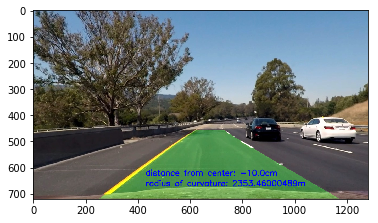

In [16]:
left = Line(7)
right = Line(7)
img = plt.imread('test_images/test6.jpg')
result = process_image(img)
result = process_image(img)

plt.figure()
plt.imshow(result)
plt.show()

In [17]:
left = Line(7)
right = Line(7)

out_dir='./'
output = out_dir+'processed_project_video_test.mp4'
clip = VideoFileClip("project_video.mp4")
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(output, audio=False)

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
[MoviePy] >>>> Building video ./processed_project_video_test.mp4
[MoviePy] Writing video ./processed_project_video_test.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

1243.22571277


  0%|                                                                                 | 1/1261 [00:00<04:11,  5.02it/s]

1157.98310245


  0%|▏                                                                                | 2/1261 [00:00<04:12,  4.99it/s]

1193.27951552


  0%|▏                                                                                | 3/1261 [00:00<04:08,  5.06it/s]

1282.15978975


  0%|▎                                                                                | 4/1261 [00:00<04:05,  5.13it/s]

1417.41466701


  0%|▎                                                                                | 5/1261 [00:00<04:00,  5.22it/s]

1506.76178805


  0%|▍                                                                                | 6/1261 [00:01<04:02,  5.18it/s]

1514.89479479


  1%|▍                                                                                | 7/1261 [00:01<03:58,  5.25it/s]

1579.90209658


  1%|▌                                                                                | 8/1261 [00:01<03:58,  5.25it/s]

2211.78744861


  1%|▌                                                                                | 9/1261 [00:01<03:57,  5.28it/s]

2208.39862319


  1%|▋                                                                               | 10/1261 [00:01<03:58,  5.24it/s]

2629.71288526


  1%|▋                                                                               | 11/1261 [00:02<03:56,  5.29it/s]

2846.03878283


  1%|▊                                                                               | 12/1261 [00:02<03:54,  5.33it/s]

2761.79394419


  1%|▊                                                                               | 13/1261 [00:02<03:58,  5.24it/s]

fit coeffs too far off [%] [ 0.97479316  0.29954646 -0.01559499]
1565.65888826


  1%|▉                                                                               | 14/1261 [00:02<04:05,  5.08it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.95997305  0.3640373  -0.03660286]
1662.16138335


  1%|▉                                                                               | 15/1261 [00:03<05:35,  3.72it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.84499672  0.36318004 -0.04946569]
1838.10948671


  1%|█                                                                               | 16/1261 [00:03<06:36,  3.14it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.71282069  0.33314955 -0.05052543]
1890.30914403


  1%|█                                                                               | 17/1261 [00:04<07:31,  2.76it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.04396935  0.45540377 -0.06208363]
1845.78334091


  1%|█▏                                                                              | 18/1261 [00:04<07:49,  2.65it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.89781472  0.41164268 -0.05520026]
1958.56541938


  2%|█▏                                                                              | 19/1261 [00:04<08:00,  2.59it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.07987544  0.38852824 -0.04433765]
1906.38299365


  2%|█▎                                                                              | 20/1261 [00:05<08:11,  2.53it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1971.84910432


  2%|█▎                                                                              | 21/1261 [00:05<08:12,  2.52it/s]

2206.49768387


  2%|█▍                                                                              | 22/1261 [00:05<06:55,  2.98it/s]

1801.78151875


  2%|█▍                                                                              | 23/1261 [00:06<06:09,  3.35it/s]

1900.22204099


  2%|█▌                                                                              | 24/1261 [00:06<05:31,  3.73it/s]

1796.92691822


  2%|█▌                                                                              | 25/1261 [00:06<05:01,  4.10it/s]

1895.26663001


  2%|█▋                                                                              | 26/1261 [00:06<04:40,  4.40it/s]

1529.37269331


  2%|█▋                                                                              | 27/1261 [00:06<04:32,  4.52it/s]

1655.53569256


  2%|█▊                                                                              | 28/1261 [00:07<04:27,  4.61it/s]

1317.52542595


  2%|█▊                                                                              | 29/1261 [00:07<04:15,  4.82it/s]

1374.55215114


  2%|█▉                                                                              | 30/1261 [00:07<04:11,  4.89it/s]

1362.29299376


  2%|█▉                                                                              | 31/1261 [00:07<04:08,  4.95it/s]

1299.34189579


  3%|██                                                                              | 32/1261 [00:07<04:05,  5.01it/s]

1702.95374956


  3%|██                                                                              | 33/1261 [00:08<04:06,  4.98it/s]

1260.11780303


  3%|██▏                                                                             | 34/1261 [00:08<04:04,  5.03it/s]

1313.38972163


  3%|██▏                                                                             | 35/1261 [00:08<03:58,  5.13it/s]

1187.45777501


  3%|██▎                                                                             | 36/1261 [00:08<03:55,  5.20it/s]

977.456941457


  3%|██▎                                                                             | 37/1261 [00:08<03:55,  5.19it/s]

922.450598143


  3%|██▍                                                                             | 38/1261 [00:08<03:55,  5.20it/s]

931.679635264


  3%|██▍                                                                             | 39/1261 [00:09<03:54,  5.21it/s]

964.323008619


  3%|██▌                                                                             | 40/1261 [00:09<03:54,  5.21it/s]

1032.16871762


  3%|██▌                                                                             | 41/1261 [00:09<03:56,  5.16it/s]

1071.10180287


  3%|██▋                                                                             | 42/1261 [00:09<03:59,  5.09it/s]

1124.26598555


  3%|██▋                                                                             | 43/1261 [00:09<03:57,  5.12it/s]

1196.11642085


  3%|██▊                                                                             | 44/1261 [00:10<03:57,  5.13it/s]

1229.25622608


  4%|██▊                                                                             | 45/1261 [00:10<03:55,  5.16it/s]

1545.35884277


  4%|██▉                                                                             | 46/1261 [00:10<03:56,  5.13it/s]

1221.87702955


  4%|██▉                                                                             | 47/1261 [00:10<03:56,  5.12it/s]

1480.33127603


  4%|███                                                                             | 48/1261 [00:10<03:58,  5.09it/s]

1292.92975485


  4%|███                                                                             | 49/1261 [00:11<04:03,  4.97it/s]

1471.82311925


  4%|███▏                                                                            | 50/1261 [00:11<04:01,  5.02it/s]

1268.3294109


  4%|███▏                                                                            | 51/1261 [00:11<03:58,  5.07it/s]

1243.85590279


  4%|███▎                                                                            | 52/1261 [00:11<04:01,  5.01it/s]

1311.71404642


  4%|███▎                                                                            | 53/1261 [00:11<03:56,  5.11it/s]

1404.12347171


  4%|███▍                                                                            | 54/1261 [00:12<03:58,  5.06it/s]

1567.02906344


  4%|███▍                                                                            | 55/1261 [00:12<04:00,  5.01it/s]

1664.55323407


  4%|███▌                                                                            | 56/1261 [00:12<04:10,  4.80it/s]

1764.77471131


  5%|███▌                                                                            | 57/1261 [00:12<04:05,  4.91it/s]

1792.1452885


  5%|███▋                                                                            | 58/1261 [00:12<04:09,  4.83it/s]

2463.92692319


  5%|███▋                                                                            | 59/1261 [00:13<04:03,  4.93it/s]

2208.24014274


  5%|███▊                                                                            | 60/1261 [00:13<04:00,  4.99it/s]

1326.87303084


  5%|███▊                                                                            | 61/1261 [00:13<03:56,  5.08it/s]

1389.57695051


  5%|███▉                                                                            | 62/1261 [00:13<03:58,  5.03it/s]

1288.77089565


  5%|███▉                                                                            | 63/1261 [00:13<04:01,  4.96it/s]

1390.57086673


  5%|████                                                                            | 64/1261 [00:14<04:05,  4.87it/s]

1555.94894196


  5%|████                                                                            | 65/1261 [00:14<03:59,  5.00it/s]

1775.21810249


  5%|████▏                                                                           | 66/1261 [00:14<03:59,  5.00it/s]

1619.31138542


  5%|████▎                                                                           | 67/1261 [00:14<04:00,  4.97it/s]

1707.33209091


  5%|████▎                                                                           | 68/1261 [00:14<03:54,  5.09it/s]

1554.46718119


  5%|████▍                                                                           | 69/1261 [00:15<03:52,  5.13it/s]

1542.09069026


  6%|████▍                                                                           | 70/1261 [00:15<03:49,  5.19it/s]

1577.52936794


  6%|████▌                                                                           | 71/1261 [00:15<03:54,  5.06it/s]

1883.76270725


  6%|████▌                                                                           | 72/1261 [00:15<03:52,  5.12it/s]

1898.8842366


  6%|████▋                                                                           | 73/1261 [00:15<03:50,  5.15it/s]

fit coeffs too far off [%] [ 0.85768444  0.28897794 -0.01218818]
1580.00644867


  6%|████▋                                                                           | 74/1261 [00:16<03:53,  5.08it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1631.06451986


  6%|████▊                                                                           | 75/1261 [00:16<05:21,  3.69it/s]

1735.04566283


  6%|████▊                                                                           | 76/1261 [00:16<04:50,  4.08it/s]

1921.93320096


  6%|████▉                                                                           | 77/1261 [00:16<04:30,  4.38it/s]

2022.49862556


  6%|████▉                                                                           | 78/1261 [00:17<04:19,  4.57it/s]

2152.4656315


  6%|█████                                                                           | 79/1261 [00:17<04:07,  4.78it/s]

2245.88448517


  6%|█████                                                                           | 80/1261 [00:17<04:06,  4.80it/s]

2405.14009475


  6%|█████▏                                                                          | 81/1261 [00:17<03:59,  4.94it/s]

2275.08533604


  7%|█████▏                                                                          | 82/1261 [00:17<03:51,  5.09it/s]

2277.16575712


  7%|█████▎                                                                          | 83/1261 [00:18<03:49,  5.14it/s]

fit coeffs too far off [%] [-0.91797737 -0.46489173  0.04298614]
9339.07715821


  7%|█████▎                                                                          | 84/1261 [00:18<03:54,  5.02it/s]

Trouble ahead! Pull Over! 6 lanes detected!
2788.51945409


  7%|█████▍                                                                          | 85/1261 [00:18<05:13,  3.75it/s]

2071.97039877


  7%|█████▍                                                                          | 86/1261 [00:18<04:44,  4.12it/s]

1919.99112565


  7%|█████▌                                                                          | 87/1261 [00:19<04:26,  4.41it/s]

1376.15614351


  7%|█████▌                                                                          | 88/1261 [00:19<04:16,  4.58it/s]

1354.13904844


  7%|█████▋                                                                          | 89/1261 [00:19<04:09,  4.70it/s]

1366.05575


  7%|█████▋                                                                          | 90/1261 [00:19<04:04,  4.78it/s]

1403.72464361


  7%|█████▊                                                                          | 91/1261 [00:19<04:02,  4.83it/s]

1434.83018923


  7%|█████▊                                                                          | 92/1261 [00:20<03:57,  4.92it/s]

1403.97086528


  7%|█████▉                                                                          | 93/1261 [00:20<03:53,  5.01it/s]

1392.78553375


  7%|█████▉                                                                          | 94/1261 [00:20<03:49,  5.08it/s]

1472.79341458


  8%|██████                                                                          | 95/1261 [00:20<03:47,  5.12it/s]

1506.27002798


  8%|██████                                                                          | 96/1261 [00:20<03:48,  5.10it/s]

1531.07600352


  8%|██████▏                                                                         | 97/1261 [00:21<03:48,  5.10it/s]

1560.85452505


  8%|██████▏                                                                         | 98/1261 [00:21<03:44,  5.19it/s]

1473.02444924


  8%|██████▎                                                                         | 99/1261 [00:21<03:44,  5.17it/s]

1253.26177453


  8%|██████▎                                                                        | 100/1261 [00:21<03:44,  5.18it/s]

1176.96270905


  8%|██████▎                                                                        | 101/1261 [00:21<03:42,  5.21it/s]

1267.30504669


  8%|██████▍                                                                        | 102/1261 [00:22<03:49,  5.04it/s]

1223.86662814


  8%|██████▍                                                                        | 103/1261 [00:22<03:46,  5.12it/s]

1296.96166598


  8%|██████▌                                                                        | 104/1261 [00:22<03:50,  5.03it/s]

1359.25121411


  8%|██████▌                                                                        | 105/1261 [00:22<03:45,  5.13it/s]

1396.7260495


  8%|██████▋                                                                        | 106/1261 [00:22<03:42,  5.20it/s]

1522.29465136


  8%|██████▋                                                                        | 107/1261 [00:23<03:42,  5.18it/s]

1476.87127652


  9%|██████▊                                                                        | 108/1261 [00:23<03:39,  5.26it/s]

1807.57316225


  9%|██████▊                                                                        | 109/1261 [00:23<03:41,  5.19it/s]

1220.4295637


  9%|██████▉                                                                        | 110/1261 [00:23<03:39,  5.24it/s]

1455.22678394


  9%|██████▉                                                                        | 111/1261 [00:23<03:38,  5.27it/s]

1386.00796491


  9%|███████                                                                        | 112/1261 [00:23<03:41,  5.18it/s]

1392.79644758


  9%|███████                                                                        | 113/1261 [00:24<03:40,  5.21it/s]

fit coeffs too far off [%] [ 0.90249444  0.506914   -0.02998124]
1008.810407


  9%|███████▏                                                                       | 114/1261 [00:24<03:43,  5.14it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1031.81994343


  9%|███████▏                                                                       | 115/1261 [00:24<05:09,  3.71it/s]

1078.61789649


  9%|███████▎                                                                       | 116/1261 [00:24<04:41,  4.06it/s]

1085.53785601


  9%|███████▎                                                                       | 117/1261 [00:25<04:24,  4.33it/s]

1150.71402649


  9%|███████▍                                                                       | 118/1261 [00:25<04:10,  4.56it/s]

1146.26618288


  9%|███████▍                                                                       | 119/1261 [00:25<04:01,  4.73it/s]

1024.68934878


 10%|███████▌                                                                       | 120/1261 [00:25<03:58,  4.78it/s]

1150.03875831


 10%|███████▌                                                                       | 121/1261 [00:25<03:53,  4.89it/s]

1206.4216859


 10%|███████▋                                                                       | 122/1261 [00:26<03:48,  4.98it/s]

1046.74646027


 10%|███████▋                                                                       | 123/1261 [00:26<03:43,  5.09it/s]

969.749885122


 10%|███████▊                                                                       | 124/1261 [00:26<03:43,  5.08it/s]

985.767817065


 10%|███████▊                                                                       | 125/1261 [00:26<03:42,  5.10it/s]

1039.84580745


 10%|███████▉                                                                       | 126/1261 [00:26<03:40,  5.14it/s]

1102.86109783


 10%|███████▉                                                                       | 127/1261 [00:27<03:39,  5.16it/s]

1116.31502963


 10%|████████                                                                       | 128/1261 [00:27<03:36,  5.23it/s]

1162.21174864


 10%|████████                                                                       | 129/1261 [00:27<03:37,  5.20it/s]

1154.52081242


 10%|████████▏                                                                      | 130/1261 [00:27<03:44,  5.04it/s]

1204.57584429


 10%|████████▏                                                                      | 131/1261 [00:27<03:39,  5.14it/s]

1191.81439979


 10%|████████▎                                                                      | 132/1261 [00:28<03:41,  5.10it/s]

1271.25670882


 11%|████████▎                                                                      | 133/1261 [00:28<03:41,  5.10it/s]

1621.55095797


 11%|████████▍                                                                      | 134/1261 [00:28<03:44,  5.03it/s]

1392.97938149


 11%|████████▍                                                                      | 135/1261 [00:28<03:40,  5.11it/s]

1624.7184159


 11%|████████▌                                                                      | 136/1261 [00:28<03:37,  5.17it/s]

1561.92661498


 11%|████████▌                                                                      | 137/1261 [00:29<03:34,  5.24it/s]

1495.38544221


 11%|████████▋                                                                      | 138/1261 [00:29<03:34,  5.24it/s]

1421.74474637


 11%|████████▋                                                                      | 139/1261 [00:29<03:36,  5.19it/s]

1552.3077109


 11%|████████▊                                                                      | 140/1261 [00:29<03:35,  5.19it/s]

1609.72397488


 11%|████████▊                                                                      | 141/1261 [00:29<03:41,  5.06it/s]

1631.21842439


 11%|████████▉                                                                      | 142/1261 [00:30<03:37,  5.14it/s]

1732.00546863


 11%|████████▉                                                                      | 143/1261 [00:30<03:39,  5.08it/s]

1706.17615184


 11%|█████████                                                                      | 144/1261 [00:30<03:38,  5.11it/s]

1730.70310986


 11%|█████████                                                                      | 145/1261 [00:30<03:35,  5.18it/s]

1770.40478683


 12%|█████████▏                                                                     | 146/1261 [00:30<03:37,  5.13it/s]

1871.87495962


 12%|█████████▏                                                                     | 147/1261 [00:31<03:38,  5.10it/s]

fit coeffs too far off [%] [ 0.94011964  0.43469849 -0.04254145]
1229.10823808


 12%|█████████▎                                                                     | 148/1261 [00:31<03:38,  5.09it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.99076993  0.46390333 -0.04390299]
1180.39637222


 12%|█████████▎                                                                     | 149/1261 [00:31<05:03,  3.66it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.74489922  0.32399053 -0.02591897]
1319.34406178


 12%|█████████▍                                                                     | 150/1261 [00:32<06:05,  3.04it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1339.19926049


 12%|█████████▍                                                                     | 151/1261 [00:32<06:50,  2.70it/s]

1408.45327697


 12%|█████████▌                                                                     | 152/1261 [00:32<05:50,  3.17it/s]

1429.83895755


 12%|█████████▌                                                                     | 153/1261 [00:32<05:08,  3.59it/s]

1513.78383412


 12%|█████████▋                                                                     | 154/1261 [00:33<04:41,  3.93it/s]

1567.98954894


 12%|█████████▋                                                                     | 155/1261 [00:33<04:24,  4.19it/s]

1595.25993385


 12%|█████████▊                                                                     | 156/1261 [00:33<04:09,  4.43it/s]

1534.89254944


 12%|█████████▊                                                                     | 157/1261 [00:33<03:57,  4.64it/s]

1478.60961633


 13%|█████████▉                                                                     | 158/1261 [00:33<03:48,  4.82it/s]

2046.54101569


 13%|█████████▉                                                                     | 159/1261 [00:34<03:42,  4.96it/s]

2107.52730468


 13%|██████████                                                                     | 160/1261 [00:34<03:38,  5.04it/s]

2006.0832713


 13%|██████████                                                                     | 161/1261 [00:34<03:36,  5.08it/s]

1714.80366243


 13%|██████████▏                                                                    | 162/1261 [00:34<03:40,  4.99it/s]

1396.3183038


 13%|██████████▏                                                                    | 163/1261 [00:34<03:46,  4.85it/s]

1389.80440773


 13%|██████████▎                                                                    | 164/1261 [00:35<03:43,  4.91it/s]

1366.61666584


 13%|██████████▎                                                                    | 165/1261 [00:35<03:45,  4.87it/s]

1497.61000576


 13%|██████████▍                                                                    | 166/1261 [00:35<03:42,  4.92it/s]

1450.44549477


 13%|██████████▍                                                                    | 167/1261 [00:35<03:40,  4.95it/s]

1603.59980604


 13%|██████████▌                                                                    | 168/1261 [00:35<03:40,  4.96it/s]

1586.6749723


 13%|██████████▌                                                                    | 169/1261 [00:36<03:43,  4.89it/s]

1790.9821798


 13%|██████████▋                                                                    | 170/1261 [00:36<03:39,  4.97it/s]

fit coeffs too far off [%] [ 0.73850129  0.17797347  0.00806323]
1314.15380795


 14%|██████████▋                                                                    | 171/1261 [00:36<03:44,  4.86it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.08839752  0.31854008 -0.00242244]
1226.99396768


 14%|██████████▊                                                                    | 172/1261 [00:37<05:00,  3.62it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.15899749  0.41180227 -0.02061657]
1184.69519428


 14%|██████████▊                                                                    | 173/1261 [00:37<06:01,  3.01it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.68674732  0.72925279 -0.06285984]
1015.74298154


 14%|██████████▉                                                                    | 174/1261 [00:37<06:36,  2.74it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.68659624  0.82074964 -0.08245682]
990.105241148


 14%|██████████▉                                                                    | 175/1261 [00:38<07:06,  2.55it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.44206625  0.78453072 -0.0878501 ]
990.635658216


 14%|███████████                                                                    | 176/1261 [00:38<07:31,  2.40it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.24835978  0.66113258 -0.06651984]
1082.78107037


 14%|███████████                                                                    | 177/1261 [00:39<07:54,  2.29it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1110.46431247


 14%|███████████▏                                                                   | 178/1261 [00:39<07:57,  2.27it/s]

1069.63470819


 14%|███████████▏                                                                   | 179/1261 [00:39<06:36,  2.73it/s]

1088.67552252


 14%|███████████▎                                                                   | 180/1261 [00:40<05:43,  3.14it/s]

1018.10015761


 14%|███████████▎                                                                   | 181/1261 [00:40<05:07,  3.51it/s]

1020.19287876


 14%|███████████▍                                                                   | 182/1261 [00:40<04:38,  3.87it/s]

1013.06286135


 15%|███████████▍                                                                   | 183/1261 [00:40<04:19,  4.15it/s]

1063.97891333


 15%|███████████▌                                                                   | 184/1261 [00:41<04:14,  4.23it/s]

880.380315622


 15%|███████████▌                                                                   | 185/1261 [00:41<04:02,  4.44it/s]

859.802495838


 15%|███████████▋                                                                   | 186/1261 [00:41<03:57,  4.52it/s]

912.919105553


 15%|███████████▋                                                                   | 187/1261 [00:41<03:51,  4.63it/s]

878.285217141


 15%|███████████▊                                                                   | 188/1261 [00:41<03:48,  4.70it/s]

902.498936095


 15%|███████████▊                                                                   | 189/1261 [00:42<03:44,  4.78it/s]

868.371756788


 15%|███████████▉                                                                   | 190/1261 [00:42<03:42,  4.81it/s]

913.52202333


 15%|███████████▉                                                                   | 191/1261 [00:42<03:42,  4.82it/s]

964.158580701


 15%|████████████                                                                   | 192/1261 [00:42<03:45,  4.74it/s]

982.07005496


 15%|████████████                                                                   | 193/1261 [00:42<03:46,  4.71it/s]

978.40702569


 15%|████████████▏                                                                  | 194/1261 [00:43<03:45,  4.72it/s]

1005.06937


 15%|████████████▏                                                                  | 195/1261 [00:43<03:43,  4.77it/s]

1091.58573843


 16%|████████████▎                                                                  | 196/1261 [00:43<03:40,  4.83it/s]

1332.04667277


 16%|████████████▎                                                                  | 197/1261 [00:43<03:38,  4.87it/s]

1380.8119967


 16%|████████████▍                                                                  | 198/1261 [00:43<03:38,  4.87it/s]

1357.3091531


 16%|████████████▍                                                                  | 199/1261 [00:44<03:38,  4.86it/s]

1597.48856854


 16%|████████████▌                                                                  | 200/1261 [00:44<03:38,  4.86it/s]

1734.71791075


 16%|████████████▌                                                                  | 201/1261 [00:44<03:38,  4.85it/s]

1555.98633935


 16%|████████████▋                                                                  | 202/1261 [00:44<03:39,  4.83it/s]

1220.95777519


 16%|████████████▋                                                                  | 203/1261 [00:44<03:37,  4.86it/s]

1213.31089678


 16%|████████████▊                                                                  | 204/1261 [00:45<03:40,  4.80it/s]

1233.05623117


 16%|████████████▊                                                                  | 205/1261 [00:45<03:40,  4.80it/s]

1268.29654401


 16%|████████████▉                                                                  | 206/1261 [00:45<03:41,  4.76it/s]

1101.82962634


 16%|████████████▉                                                                  | 207/1261 [00:45<03:41,  4.77it/s]

1190.27497489


 16%|█████████████                                                                  | 208/1261 [00:45<03:41,  4.75it/s]

1262.49562319


 17%|█████████████                                                                  | 209/1261 [00:46<03:43,  4.70it/s]

1259.19448391


 17%|█████████████▏                                                                 | 210/1261 [00:46<03:42,  4.73it/s]

1317.37626994


 17%|█████████████▏                                                                 | 211/1261 [00:46<03:42,  4.72it/s]

1177.53273289


 17%|█████████████▎                                                                 | 212/1261 [00:46<03:38,  4.81it/s]

1113.08911776


 17%|█████████████▎                                                                 | 213/1261 [00:47<03:44,  4.67it/s]

1163.60118086


 17%|█████████████▍                                                                 | 214/1261 [00:47<03:41,  4.73it/s]

1154.73948537


 17%|█████████████▍                                                                 | 215/1261 [00:47<03:40,  4.75it/s]

1231.06249247


 17%|█████████████▌                                                                 | 216/1261 [00:47<03:40,  4.75it/s]

1359.06900957


 17%|█████████████▌                                                                 | 217/1261 [00:47<03:41,  4.71it/s]

1542.04061509


 17%|█████████████▋                                                                 | 218/1261 [00:48<03:40,  4.73it/s]

1364.82171537


 17%|█████████████▋                                                                 | 219/1261 [00:48<03:46,  4.60it/s]

1815.88885214


 17%|█████████████▊                                                                 | 220/1261 [00:48<03:44,  4.64it/s]

1738.68764154


 18%|█████████████▊                                                                 | 221/1261 [00:48<03:45,  4.61it/s]

1775.69874541


 18%|█████████████▉                                                                 | 222/1261 [00:48<03:43,  4.65it/s]

2034.82558409


 18%|█████████████▉                                                                 | 223/1261 [00:49<03:42,  4.66it/s]

1373.728649


 18%|██████████████                                                                 | 224/1261 [00:49<03:40,  4.70it/s]

1299.69048737


 18%|██████████████                                                                 | 225/1261 [00:49<03:42,  4.66it/s]

1314.71274925


 18%|██████████████▏                                                                | 226/1261 [00:49<03:41,  4.68it/s]

1400.72121588


 18%|██████████████▏                                                                | 227/1261 [00:50<03:39,  4.70it/s]

1543.35768046


 18%|██████████████▎                                                                | 228/1261 [00:50<03:45,  4.59it/s]

1612.91154732


 18%|██████████████▎                                                                | 229/1261 [00:50<03:43,  4.62it/s]

1736.97132316


 18%|██████████████▍                                                                | 230/1261 [00:50<03:44,  4.60it/s]

1658.20536547


 18%|██████████████▍                                                                | 231/1261 [00:50<03:41,  4.65it/s]

1686.42466033


 18%|██████████████▌                                                                | 232/1261 [00:51<03:42,  4.63it/s]

1556.56983553


 18%|██████████████▌                                                                | 233/1261 [00:51<03:45,  4.56it/s]

1536.22183492


 19%|██████████████▋                                                                | 234/1261 [00:51<03:43,  4.60it/s]

1461.2222729


 19%|██████████████▋                                                                | 235/1261 [00:51<03:41,  4.62it/s]

1231.11790132


 19%|██████████████▊                                                                | 236/1261 [00:52<03:42,  4.60it/s]

1205.2822021


 19%|██████████████▊                                                                | 237/1261 [00:52<03:45,  4.55it/s]

1166.12845401


 19%|██████████████▉                                                                | 238/1261 [00:52<03:46,  4.51it/s]

1145.25723948


 19%|██████████████▉                                                                | 239/1261 [00:52<03:46,  4.52it/s]

1126.15240583


 19%|███████████████                                                                | 240/1261 [00:52<03:39,  4.65it/s]

1201.09693427


 19%|███████████████                                                                | 241/1261 [00:53<03:36,  4.70it/s]

1265.12668915


 19%|███████████████▏                                                               | 242/1261 [00:53<03:34,  4.75it/s]

1169.37821993


 19%|███████████████▏                                                               | 243/1261 [00:53<03:36,  4.71it/s]

1228.73134212


 19%|███████████████▎                                                               | 244/1261 [00:53<03:41,  4.59it/s]

1219.81065407


 19%|███████████████▎                                                               | 245/1261 [00:53<03:40,  4.62it/s]

1063.06046227


 20%|███████████████▍                                                               | 246/1261 [00:54<03:36,  4.70it/s]

1063.98209894


 20%|███████████████▍                                                               | 247/1261 [00:54<03:39,  4.61it/s]

1099.16154463


 20%|███████████████▌                                                               | 248/1261 [00:54<03:40,  4.60it/s]

1120.07633015


 20%|███████████████▌                                                               | 249/1261 [00:54<03:41,  4.56it/s]

1188.47623399


 20%|███████████████▋                                                               | 250/1261 [00:55<03:39,  4.60it/s]

1192.28277549


 20%|███████████████▋                                                               | 251/1261 [00:55<03:37,  4.64it/s]

1255.39762019


 20%|███████████████▊                                                               | 252/1261 [00:55<03:37,  4.63it/s]

1289.07430859


 20%|███████████████▊                                                               | 253/1261 [00:55<03:33,  4.72it/s]

1353.36202165


 20%|███████████████▉                                                               | 254/1261 [00:55<03:33,  4.71it/s]

1361.41439337


 20%|███████████████▉                                                               | 255/1261 [00:56<03:32,  4.73it/s]

1386.63173166


 20%|████████████████                                                               | 256/1261 [00:56<03:31,  4.75it/s]

1273.75681849


 20%|████████████████                                                               | 257/1261 [00:56<03:35,  4.67it/s]

1091.65105364


 20%|████████████████▏                                                              | 258/1261 [00:56<03:31,  4.74it/s]

1121.53516729


 21%|████████████████▏                                                              | 259/1261 [00:56<03:32,  4.71it/s]

1175.22460021


 21%|████████████████▎                                                              | 260/1261 [00:57<03:32,  4.70it/s]

1279.8592952


 21%|████████████████▎                                                              | 261/1261 [00:57<03:31,  4.73it/s]

1303.48836435


 21%|████████████████▍                                                              | 262/1261 [00:57<03:29,  4.77it/s]

1383.97654544


 21%|████████████████▍                                                              | 263/1261 [00:57<03:27,  4.81it/s]

1415.29952327


 21%|████████████████▌                                                              | 264/1261 [00:58<03:31,  4.71it/s]

1483.50550786


 21%|████████████████▌                                                              | 265/1261 [00:58<03:30,  4.73it/s]

1435.54243865


 21%|████████████████▋                                                              | 266/1261 [00:58<03:29,  4.75it/s]

1414.39926134


 21%|████████████████▋                                                              | 267/1261 [00:58<03:31,  4.71it/s]

1415.83580784


 21%|████████████████▊                                                              | 268/1261 [00:58<03:30,  4.72it/s]

1440.21690645


 21%|████████████████▊                                                              | 269/1261 [00:59<03:38,  4.54it/s]

1587.83951616


 21%|████████████████▉                                                              | 270/1261 [00:59<03:33,  4.65it/s]

1584.06709504


 21%|████████████████▉                                                              | 271/1261 [00:59<03:34,  4.61it/s]

1319.94645393


 22%|█████████████████                                                              | 272/1261 [00:59<03:32,  4.64it/s]

1431.14514594


 22%|█████████████████                                                              | 273/1261 [00:59<03:33,  4.63it/s]

1483.48587606


 22%|█████████████████▏                                                             | 274/1261 [01:00<03:30,  4.68it/s]

1576.67220599


 22%|█████████████████▏                                                             | 275/1261 [01:00<03:31,  4.67it/s]

1690.86342842


 22%|█████████████████▎                                                             | 276/1261 [01:00<03:29,  4.70it/s]

1709.82377525


 22%|█████████████████▎                                                             | 277/1261 [01:00<03:29,  4.71it/s]

1812.97969004


 22%|█████████████████▍                                                             | 278/1261 [01:00<03:26,  4.75it/s]

1690.75791849


 22%|█████████████████▍                                                             | 279/1261 [01:01<03:26,  4.75it/s]

1793.01609631


 22%|█████████████████▌                                                             | 280/1261 [01:01<03:25,  4.78it/s]

2114.36287733


 22%|█████████████████▌                                                             | 281/1261 [01:01<03:28,  4.70it/s]

2035.53317444


 22%|█████████████████▋                                                             | 282/1261 [01:01<03:35,  4.55it/s]

2244.71791437


 22%|█████████████████▋                                                             | 283/1261 [01:02<03:38,  4.48it/s]

1764.08711357


 23%|█████████████████▊                                                             | 284/1261 [01:02<03:34,  4.55it/s]

1976.95649737


 23%|█████████████████▊                                                             | 285/1261 [01:02<03:35,  4.53it/s]

2265.90387812


 23%|█████████████████▉                                                             | 286/1261 [01:02<03:37,  4.48it/s]

2222.78088226


 23%|█████████████████▉                                                             | 287/1261 [01:02<03:33,  4.57it/s]

2388.76797994


 23%|██████████████████                                                             | 288/1261 [01:03<03:33,  4.55it/s]

2439.91906518


 23%|██████████████████                                                             | 289/1261 [01:03<03:32,  4.57it/s]

2587.10386215


 23%|██████████████████▏                                                            | 290/1261 [01:03<03:30,  4.62it/s]

2213.56087763


 23%|██████████████████▏                                                            | 291/1261 [01:03<03:31,  4.58it/s]

2472.23568966


 23%|██████████████████▎                                                            | 292/1261 [01:04<03:28,  4.64it/s]

2389.77041587


 23%|██████████████████▎                                                            | 293/1261 [01:04<03:25,  4.71it/s]

2318.64425865


 23%|██████████████████▍                                                            | 294/1261 [01:04<03:23,  4.74it/s]

2144.15179649


 23%|██████████████████▍                                                            | 295/1261 [01:04<03:25,  4.71it/s]

2157.97144705


 23%|██████████████████▌                                                            | 296/1261 [01:04<03:24,  4.72it/s]

2199.64098313


 24%|██████████████████▌                                                            | 297/1261 [01:05<03:29,  4.59it/s]

2515.65405962


 24%|██████████████████▋                                                            | 298/1261 [01:05<03:29,  4.59it/s]

2699.415426


 24%|██████████████████▋                                                            | 299/1261 [01:05<03:27,  4.64it/s]

2906.0650608


 24%|██████████████████▊                                                            | 300/1261 [01:05<03:33,  4.51it/s]

3206.80056316


 24%|██████████████████▊                                                            | 301/1261 [01:06<03:34,  4.48it/s]

3870.4327438


 24%|██████████████████▉                                                            | 302/1261 [01:06<03:33,  4.49it/s]

3702.58304302


 24%|██████████████████▉                                                            | 303/1261 [01:06<03:36,  4.43it/s]

3620.88542305


 24%|███████████████████                                                            | 304/1261 [01:06<03:36,  4.43it/s]

fit coeffs too far off [%] [-1.63722069 -0.71310995  0.03037542]
4166.78883332


 24%|███████████████████                                                            | 305/1261 [01:06<03:35,  4.43it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.62991706 -0.65000107  0.01522787]
4438.28454455


 24%|███████████████████▏                                                           | 306/1261 [01:07<05:01,  3.16it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.23443605 -0.55644134  0.02222918]
8282.12349128


 24%|███████████████████▏                                                           | 307/1261 [01:07<05:48,  2.73it/s]

Trouble ahead! Pull Over! 6 lanes detected!
5072.53084965


 24%|███████████████████▎                                                           | 308/1261 [01:08<06:14,  2.55it/s]

5528.36378882


 25%|███████████████████▎                                                           | 309/1261 [01:08<05:23,  2.94it/s]

7188.70124577


 25%|███████████████████▍                                                           | 310/1261 [01:08<04:43,  3.36it/s]

fit coeffs too far off [%] [-0.89326711 -0.34101771  0.00548795]
22462.9606114


 25%|███████████████████▍                                                           | 311/1261 [01:09<04:19,  3.66it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.83629195 -0.35077221  0.00847025]
18876.9556556


 25%|███████████████████▌                                                           | 312/1261 [01:09<05:27,  2.89it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.70970005 -0.48289906  0.11351642]
17333.2639788


 25%|███████████████████▌                                                           | 313/1261 [01:10<06:07,  2.58it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.87150927 -0.50918186  0.10454461]
fit coeffs too far off [%] [-0.80988022 -0.34574074  0.00944792]
37809.0154286


 25%|███████████████████▋                                                           | 314/1261 [01:10<06:35,  2.39it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.7540798  -0.4798949   0.09402175]
17366.5645099


 25%|███████████████████▋                                                           | 315/1261 [01:11<08:19,  1.89it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.09953286 -0.5338004   0.08405445]
45441.6560386


 25%|███████████████████▊                                                           | 316/1261 [01:11<08:10,  1.93it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.70600904 -0.38129302  0.06255745]
17987.8952389


 25%|███████████████████▊                                                           | 317/1261 [01:12<07:53,  1.99it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 2.05483319  0.27589926  0.00265589]
17283.8554478


 25%|███████████████████▉                                                           | 318/1261 [01:12<07:53,  1.99it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.28971373 -0.50228278  0.05690294]
fit coeffs too far off [%] [ 3.22578781  0.45843065  0.00658696]
24611.1625053


 25%|███████████████████▉                                                           | 319/1261 [01:13<07:52,  1.99it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.86540075 -0.68015067  0.06666258]
fit coeffs too far off [%] [  2.77311919e+00   4.80593038e-01  -1.49715942e-03]
11795.8358966


 25%|████████████████████                                                           | 320/1261 [01:14<09:06,  1.72it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.97620192 -0.55053768  0.02270792]
fit coeffs too far off [%] [ 2.17125627  0.29118869  0.0088526 ]
9568.43972608


 25%|████████████████████                                                           | 321/1261 [01:14<09:44,  1.61it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.34240458  0.26996998  0.00354077]
6952.01803147


 26%|████████████████████▏                                                          | 322/1261 [01:15<10:15,  1.52it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [  1.96839075e+00   5.21891180e-01  -1.62676364e-03]
6980.76446949


 26%|████████████████████▏                                                          | 323/1261 [01:15<09:21,  1.67it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.19201487  0.8368563  -0.01879024]
8631.64205376


 26%|████████████████████▎                                                          | 324/1261 [01:16<08:36,  1.81it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.33795183  0.65424858 -0.01071112]
10189.6782777


 26%|████████████████████▎                                                          | 325/1261 [01:16<08:17,  1.88it/s]

Trouble ahead! Pull Over! 6 lanes detected!
8236.26827217


 26%|████████████████████▍                                                          | 326/1261 [01:17<08:01,  1.94it/s]

8532.38316354


 26%|████████████████████▍                                                          | 327/1261 [01:17<06:35,  2.36it/s]

8566.43239708


 26%|████████████████████▌                                                          | 328/1261 [01:17<05:36,  2.77it/s]

fit coeffs too far off [%] [-0.20834654  0.89098282 -0.03259794]
11514.4512351


 26%|████████████████████▌                                                          | 329/1261 [01:17<04:54,  3.17it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.68782037  0.71968615 -0.01072908]
fit coeffs too far off [%] [-1.1772565  -0.67991493  0.017027  ]
32566.9560762


 26%|████████████████████▋                                                          | 330/1261 [01:18<05:46,  2.69it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.11065084  0.79636701  0.00139148]
60395.1342767


 26%|████████████████████▋                                                          | 331/1261 [01:19<07:41,  2.01it/s]

Trouble ahead! Pull Over! 6 lanes detected!
23381.4756252


 26%|████████████████████▊                                                          | 332/1261 [01:19<07:25,  2.09it/s]

fit coeffs too far off [%] [-2.27343932 -0.94807857  0.02107848]
fit coeffs too far off [%] [-0.71058844 -0.18518699 -0.01416033]
23255.7194762


 26%|████████████████████▊                                                          | 333/1261 [01:19<06:09,  2.51it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.83467246 -0.32001353 -0.00969554]
45824.8506893


 26%|████████████████████▉                                                          | 334/1261 [01:20<07:26,  2.07it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.82288526 -0.26847981 -0.01208577]
43465.0257664


 27%|████████████████████▉                                                          | 335/1261 [01:21<07:19,  2.11it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.39982772  0.7068072  -0.03049382]
fit coeffs too far off [%] [-0.70950993 -0.49165004  0.00943954]
89021.5751471


 27%|█████████████████████                                                          | 336/1261 [01:21<07:29,  2.06it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.17315535  0.52599827 -0.02818987]
fit coeffs too far off [%] [-1.16643963 -0.8436177   0.01818616]
194622.290879


 27%|█████████████████████                                                          | 337/1261 [01:22<08:39,  1.78it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.93953153 -0.78762431  0.02993167]
50307.8609993


 27%|█████████████████████▏                                                         | 338/1261 [01:23<09:27,  1.63it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.85453822 -0.30900601  0.00668346]
fit coeffs too far off [%] [-0.71428268 -0.67358828  0.03471307]
18460.0970625


 27%|█████████████████████▏                                                         | 339/1261 [01:23<08:44,  1.76it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
27858.2611839


 27%|█████████████████████▎                                                         | 340/1261 [01:24<09:27,  1.62it/s]

fit coeffs too far off [%] [-4.77133552 -0.6657165   0.00562482]
10734.508167


 27%|█████████████████████▎                                                         | 341/1261 [01:24<07:31,  2.04it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.12804087  0.87383175  0.02740447]
8727.80977059


 27%|█████████████████████▍                                                         | 342/1261 [01:24<07:19,  2.09it/s]

Trouble ahead! Pull Over! 6 lanes detected!
8768.96199014


 27%|█████████████████████▍                                                         | 343/1261 [01:25<07:07,  2.15it/s]

7167.80183759


 27%|█████████████████████▌                                                         | 344/1261 [01:25<06:00,  2.54it/s]

fit coeffs too far off [%] [-0.14247137 -1.48507781 -0.01584275]
8976.70283935


 27%|█████████████████████▌                                                         | 345/1261 [01:25<05:10,  2.95it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.34983601 -3.3649836  -0.03324393]
fit coeffs too far off [%] [-0.44755076 -0.53704019  0.02055087]
13427.0348025


 27%|█████████████████████▋                                                         | 346/1261 [01:26<05:50,  2.61it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.70384774 -4.27798296 -0.01848971]
22638.0011597


 28%|█████████████████████▋                                                         | 347/1261 [01:26<07:18,  2.08it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.63103643 -0.67828164  0.01970761]
48499.8347252


 28%|█████████████████████▊                                                         | 348/1261 [01:27<07:11,  2.12it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-4.83752687  0.29910409  0.00641525]
fit coeffs too far off [%] [-1.02957078 -0.81071765  0.01323963]
112113.966639


 28%|█████████████████████▊                                                         | 349/1261 [01:27<07:13,  2.11it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.03843203 -1.02698584  0.02010818]
110072.917579


 28%|█████████████████████▉                                                         | 350/1261 [01:28<08:32,  1.78it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [  1.04040278e+00   2.22815445e-01  -9.33289280e-04]
fit coeffs too far off [%] [-0.56138387 -0.66388853  0.01338252]
18217.0634791


 28%|█████████████████████▉                                                         | 351/1261 [01:29<08:07,  1.87it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
57723.7822914


 28%|██████████████████████                                                         | 352/1261 [01:29<08:35,  1.76it/s]

fit coeffs too far off [%] [  1.09802847e+01   4.13096968e+00   6.98226483e-03]
7415.07074051


 28%|██████████████████████                                                         | 353/1261 [01:29<06:54,  2.19it/s]

Trouble ahead! Pull Over! 6 lanes detected!
17130.3633289


 28%|██████████████████████▏                                                        | 354/1261 [01:30<06:51,  2.20it/s]

fit coeffs too far off [%] [-0.3688848   0.50104555  0.00518292]
25481.6824152


 28%|██████████████████████▏                                                        | 355/1261 [01:30<05:43,  2.63it/s]

Trouble ahead! Pull Over! 6 lanes detected!
18452.7834649


 28%|██████████████████████▎                                                        | 356/1261 [01:31<06:09,  2.45it/s]

fit coeffs too far off [%] [  7.34798856 -19.74776094  -0.01974969]
5113.51347755


 28%|██████████████████████▎                                                        | 357/1261 [01:31<05:17,  2.85it/s]

Trouble ahead! Pull Over! 6 lanes detected!
5712.06208596


 28%|██████████████████████▍                                                        | 358/1261 [01:31<06:04,  2.48it/s]

fit coeffs too far off [%] [-1.02327533 -0.60622499  0.03845189]
135586.21553


 28%|██████████████████████▍                                                        | 359/1261 [01:32<05:11,  2.89it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.15494332 -0.63069313  0.03399532]
22915.59927


 29%|██████████████████████▌                                                        | 360/1261 [01:32<05:40,  2.65it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.61872999 -0.8558919   0.03866632]
9490.87805438


 29%|██████████████████████▌                                                        | 361/1261 [01:32<06:12,  2.41it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.25093453 -1.27257844  0.06561052]
6809.81272182


 29%|██████████████████████▋                                                        | 362/1261 [01:33<06:16,  2.39it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.69665038 -1.46468958  0.06691617]
5362.72944678


 29%|██████████████████████▋                                                        | 363/1261 [01:33<06:35,  2.27it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-3.53188462 -2.0870552   0.1082226 ]
5299.47218655


 29%|██████████████████████▊                                                        | 364/1261 [01:34<06:42,  2.23it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-3.5703596  -1.98119152  0.10456905]
5531.65016145


 29%|██████████████████████▊                                                        | 365/1261 [01:34<06:40,  2.24it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.67081364  0.73264116 -0.0097785 ]
3617.87779364


 29%|██████████████████████▉                                                        | 366/1261 [01:35<06:49,  2.18it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.72670734  1.2215284  -0.0069362 ]
2560.72447283


 29%|██████████████████████▉                                                        | 367/1261 [01:35<06:49,  2.18it/s]

Trouble ahead! Pull Over! 6 lanes detected!
5333.33258146


 29%|███████████████████████                                                        | 368/1261 [01:36<06:56,  2.14it/s]

6148.33491231


 29%|███████████████████████                                                        | 369/1261 [01:36<05:48,  2.56it/s]

6446.63063818


 29%|███████████████████████▏                                                       | 370/1261 [01:36<05:00,  2.97it/s]

10238.8425557


 29%|███████████████████████▏                                                       | 371/1261 [01:36<04:32,  3.27it/s]

fit coeffs too far off [%] [-1.0972735  -1.06387035  0.01300564]
48841.1221888


 30%|███████████████████████▎                                                       | 372/1261 [01:37<04:05,  3.63it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.99047501 -1.10284598  0.01609842]
511960.30232


 30%|███████████████████████▎                                                       | 373/1261 [01:37<05:00,  2.95it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.33715563 -1.26318843  0.01029411]
17497.6364836


 30%|███████████████████████▍                                                       | 374/1261 [01:38<05:44,  2.58it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.71805122 -0.59747969  0.0013072 ]
22536.2541221


 30%|███████████████████████▍                                                       | 375/1261 [01:38<06:10,  2.39it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.78782883 -0.48026732  0.01349225]
fit coeffs too far off [%] [-1.81221977 -0.89338029 -0.00621107]
14963.6735285


 30%|███████████████████████▌                                                       | 376/1261 [01:39<06:24,  2.30it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.92893629 -0.60491659  0.01024143]
fit coeffs too far off [%] [ -5.15759804e+00  -2.65407490e+00   2.26288229e-04]
26142.1817359


 30%|███████████████████████▌                                                       | 377/1261 [01:39<07:49,  1.88it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.14523625 -0.77653611  0.01112968]
fit coeffs too far off [%] [ 0.93239336  0.69259402 -0.01479014]
17717.6311956


 30%|███████████████████████▋                                                       | 378/1261 [01:40<08:45,  1.68it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ -1.32817237e+00  -1.01482322e+00   3.11340801e-04]
9834.53727982


 30%|███████████████████████▋                                                       | 379/1261 [01:41<09:18,  1.58it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.55771056 -1.31772575 -0.0129599 ]
6466.24505091


 30%|███████████████████████▊                                                       | 380/1261 [01:41<08:31,  1.72it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.59652738 -1.42665515 -0.02592837]
7376.12246663


 30%|███████████████████████▊                                                       | 381/1261 [01:42<07:53,  1.86it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.63171339 -1.44786743 -0.03028744]
fit coeffs too far off [%] [-0.44651886 -0.60271765  0.01128794]
10151.0903436


 30%|███████████████████████▉                                                       | 382/1261 [01:42<07:37,  1.92it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.87749543 -0.82011405  0.00541761]
24861.9968167


 30%|███████████████████████▉                                                       | 383/1261 [01:43<08:42,  1.68it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.17833797 -1.16867951  0.00443849]
19177.9908239


 30%|████████████████████████                                                       | 384/1261 [01:43<08:05,  1.81it/s]

Trouble ahead! Pull Over! 6 lanes detected!
14635.0575785


 31%|████████████████████████                                                       | 385/1261 [01:44<07:43,  1.89it/s]

17861.7976656


 31%|████████████████████████▏                                                      | 386/1261 [01:44<06:14,  2.33it/s]

31934.3875825


 31%|████████████████████████▏                                                      | 387/1261 [01:44<05:17,  2.76it/s]

fit coeffs too far off [%] [ -8.70680510e-01  -4.66402980e-01  -5.01121841e-04]
101641.929714


 31%|████████████████████████▎                                                      | 388/1261 [01:44<04:35,  3.17it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.06700998  0.87702467 -0.04034091]
fit coeffs too far off [%] [ 1.4571837   0.63464613  0.00343991]
12140.0476336


 31%|████████████████████████▎                                                      | 389/1261 [01:45<05:25,  2.68it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.0068718   1.01904847 -0.05418925]
fit coeffs too far off [%] [ -1.96348807e+00  -3.29702982e-01   2.48868595e-04]
27376.580634


 31%|████████████████████████▍                                                      | 390/1261 [01:46<07:04,  2.05it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.22905033  1.08484773 -0.05556663]
15380.8660827


 31%|████████████████████████▍                                                      | 391/1261 [01:46<07:54,  1.83it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.50095983  1.30112852 -0.06717355]
16985.927149


 31%|████████████████████████▌                                                      | 392/1261 [01:47<07:25,  1.95it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.75535501  1.40917009 -0.05655649]
13656.6849573


 31%|████████████████████████▌                                                      | 393/1261 [01:47<07:18,  1.98it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.74104831  1.62267371 -0.07419067]
12038.2843498


 31%|████████████████████████▋                                                      | 394/1261 [01:48<07:06,  2.03it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.32401785 -1.13671826 -0.01199299]
30447.8340146


 31%|████████████████████████▋                                                      | 395/1261 [01:48<06:48,  2.12it/s]

Trouble ahead! Pull Over! 6 lanes detected!
11879.6330115


 31%|████████████████████████▊                                                      | 396/1261 [01:49<06:42,  2.15it/s]

20161.548


 31%|████████████████████████▊                                                      | 397/1261 [01:49<05:36,  2.57it/s]

12025.9780051


 32%|████████████████████████▉                                                      | 398/1261 [01:49<04:48,  3.00it/s]

fit coeffs too far off [%] [ 0.6948399   0.71932145  0.00478055]
8944.51823091


 32%|████████████████████████▉                                                      | 399/1261 [01:49<04:19,  3.33it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 2.414783    1.8882201   0.00847166]
7687.15414664


 32%|█████████████████████████                                                      | 400/1261 [01:50<05:11,  2.77it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 2.88097039  2.17405262  0.01227166]
7884.0406579


 32%|█████████████████████████                                                      | 401/1261 [01:50<05:42,  2.51it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 2.16668641  1.85130177  0.01177491]
8688.66449684


 32%|█████████████████████████▏                                                     | 402/1261 [01:51<06:04,  2.36it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.4627803   0.56845218  0.00161613]
18814.4995039


 32%|█████████████████████████▏                                                     | 403/1261 [01:51<06:20,  2.25it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.94390843 -0.19970223 -0.0084674 ]
fit coeffs too far off [%] [ 1.00473463  1.31967289  0.01050944]
91676.6891506


 32%|█████████████████████████▎                                                     | 404/1261 [01:52<06:21,  2.24it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.91920927 -0.24951734  0.00466441]
67270.8814412


 32%|█████████████████████████▎                                                     | 405/1261 [01:52<07:21,  1.94it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.12624789 -0.23954799 -0.00707072]
fit coeffs too far off [%] [ 0.56939301  0.57944406  0.0091117 ]
45421.7415473


 32%|█████████████████████████▍                                                     | 406/1261 [01:53<07:17,  1.96it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.33207582 -0.25542019 -0.01130253]
22174.0774367


 32%|█████████████████████████▍                                                     | 407/1261 [01:54<08:13,  1.73it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.2987507  -0.24449412 -0.01055435]
fit coeffs too far off [%] [-1.56595097 -0.98832298 -0.01419862]
28607.3682911


 32%|█████████████████████████▌                                                     | 408/1261 [01:54<07:58,  1.78it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.13977802 -0.36492526 -0.01057582]
11984.1506668


 32%|█████████████████████████▌                                                     | 409/1261 [01:55<08:32,  1.66it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.7083736  -0.23208786 -0.01075827]
fit coeffs too far off [%] [ -8.71390929e-01  -3.61942674e+00  -3.20386149e-03]
57907.6641363


 33%|█████████████████████████▋                                                     | 410/1261 [01:55<07:59,  1.77it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
52554.8859232


 33%|█████████████████████████▋                                                     | 411/1261 [01:56<08:35,  1.65it/s]

fit coeffs too far off [%] [  3.42978474e+00   1.09019240e+00   2.10075848e-03]
32260.6975589


 33%|█████████████████████████▊                                                     | 412/1261 [01:56<06:53,  2.05it/s]

Trouble ahead! Pull Over! 6 lanes detected!
28489.0212065


 33%|█████████████████████████▊                                                     | 413/1261 [01:57<06:53,  2.05it/s]

fit coeffs too far off [%] [ -1.92234330e+00   7.69194576e-02  -9.61240585e-04]
fit coeffs too far off [%] [ 0.98345138  0.77289035  0.00509707]
33130.2752817


 33%|█████████████████████████▉                                                     | 414/1261 [01:57<05:44,  2.46it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-5.9861322   0.19251695  0.01832744]
7743.88114799


 33%|█████████████████████████▉                                                     | 415/1261 [01:58<06:54,  2.04it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-5.07833173  0.34115124 -0.00879455]
11441.1015317


 33%|██████████████████████████                                                     | 416/1261 [01:58<06:44,  2.09it/s]

Trouble ahead! Pull Over! 6 lanes detected!
7548.02646842


 33%|██████████████████████████                                                     | 417/1261 [01:59<06:35,  2.14it/s]

7386.49341868


 33%|██████████████████████████▏                                                    | 418/1261 [01:59<05:26,  2.58it/s]

fit coeffs too far off [%] [-1.45268634 -1.14479911 -0.00704718]
10961.310726


 33%|██████████████████████████▏                                                    | 419/1261 [01:59<04:44,  2.96it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.31792324 -1.11744214 -0.01235983]
16808.3887153


 33%|██████████████████████████▎                                                    | 420/1261 [01:59<05:28,  2.56it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.82605581 -0.70499986 -0.00770148]
26462.8770207


 33%|██████████████████████████▍                                                    | 421/1261 [02:00<05:50,  2.40it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.38885394 -0.62787839 -0.01713687]
10379.3757398


 33%|██████████████████████████▍                                                    | 422/1261 [02:00<05:59,  2.33it/s]

Trouble ahead! Pull Over! 6 lanes detected!
11322.3991567


 34%|██████████████████████████▌                                                    | 423/1261 [02:01<06:07,  2.28it/s]

9807.31844244


 34%|██████████████████████████▌                                                    | 424/1261 [02:01<05:07,  2.72it/s]

fit coeffs too far off [%] [ 0.96536165  0.6109734   0.00119331]
6967.13124381


 34%|██████████████████████████▋                                                    | 425/1261 [02:01<04:29,  3.10it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.83812359  0.99337315  0.01238898]
10372.0726637


 34%|██████████████████████████▋                                                    | 426/1261 [02:02<05:04,  2.74it/s]

Trouble ahead! Pull Over! 6 lanes detected!
12347.3235388


 34%|██████████████████████████▊                                                    | 427/1261 [02:02<05:27,  2.55it/s]

15949.267174


 34%|██████████████████████████▊                                                    | 428/1261 [02:02<04:37,  3.00it/s]

16058.171372


 34%|██████████████████████████▉                                                    | 429/1261 [02:03<04:10,  3.32it/s]

fit coeffs too far off [%] [-1.11344947 -0.68539655 -0.00724312]
58136.9083111


 34%|██████████████████████████▉                                                    | 430/1261 [02:03<03:49,  3.62it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.85930999 -0.98133157 -0.00218943]
15455.8775152


 34%|███████████████████████████                                                    | 431/1261 [02:03<04:46,  2.90it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.43396947 -0.18299555 -0.01437286]
fit coeffs too far off [%] [-1.38821969 -0.82718933 -0.0023472 ]
30330.1997422


 34%|███████████████████████████                                                    | 432/1261 [02:04<05:11,  2.66it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
26470.5281794


 34%|███████████████████████████▏                                                   | 433/1261 [02:04<06:31,  2.11it/s]

fit coeffs too far off [%] [-2.33940202 -0.23805436 -0.01723503]
fit coeffs too far off [%] [ -5.72258449e-01  -1.29806101e+00  -1.25258161e-03]
15147.4088923


 34%|███████████████████████████▏                                                   | 434/1261 [02:05<05:31,  2.49it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-3.78169696 -0.43004015 -0.00622667]
16462.0392772


 34%|███████████████████████████▎                                                   | 435/1261 [02:05<06:53,  2.00it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-4.38531867 -0.55616898  0.01553524]
fit coeffs too far off [%] [ -1.42810258e+00   8.79624997e-01  -7.81716255e-04]
32460.2088364


 35%|███████████████████████████▎                                                   | 436/1261 [02:06<06:40,  2.06it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-5.20992203 -0.79900827  0.05842121]
12871.4433396


 35%|███████████████████████████▍                                                   | 437/1261 [02:07<07:53,  1.74it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-6.14270221 -0.78381383  0.04822785]
29137.0643818


 35%|███████████████████████████▍                                                   | 438/1261 [02:07<07:36,  1.80it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-6.63328396 -1.04307789  0.10834897]
fit coeffs too far off [%] [-2.68211077 -1.80980761 -0.00853739]
10825.9484607


 35%|███████████████████████████▌                                                   | 439/1261 [02:08<07:22,  1.86it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-10.20572275  -1.17983815   0.15512192]
fit coeffs too far off [%] [-10.82573584  -4.55982232  -0.02897674]
5224.48304933


 35%|███████████████████████████▌                                                   | 440/1261 [02:08<08:11,  1.67it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
4272.00238186


 35%|███████████████████████████▋                                                   | 441/1261 [02:09<08:32,  1.60it/s]

fit coeffs too far off [%] [  1.03026777e-01   5.82989358e-01   5.58648372e-04]
4994.06799379


 35%|███████████████████████████▋                                                   | 442/1261 [02:09<06:47,  2.01it/s]

Trouble ahead! Pull Over! 6 lanes detected!
4622.53933199


 35%|███████████████████████████▊                                                   | 443/1261 [02:10<06:42,  2.03it/s]

fit coeffs too far off [%] [-0.21340813  1.05293179  0.00531783]
5373.28134227


 35%|███████████████████████████▊                                                   | 444/1261 [02:10<05:28,  2.49it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.43001015 -0.68436656  0.01543739]
6089.77363328


 35%|███████████████████████████▉                                                   | 445/1261 [02:10<05:49,  2.33it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.14277528 -0.75466442  0.01373143]
fit coeffs too far off [%] [-0.61522702 -0.79429885  0.00873989]
8869.09596377


 35%|███████████████████████████▉                                                   | 446/1261 [02:11<06:00,  2.26it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.65569284 -0.5374804  -0.00671558]
8820.09977421


 35%|████████████████████████████                                                   | 447/1261 [02:12<07:11,  1.89it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ -8.43991785e-01  -8.30983849e-01  -4.99200663e-04]
17127.276088


 36%|████████████████████████████                                                   | 448/1261 [02:12<06:49,  1.99it/s]

Trouble ahead! Pull Over! 6 lanes detected!
4929.42529244


 36%|████████████████████████████▏                                                  | 449/1261 [02:13<06:33,  2.07it/s]

fit coeffs too far off [%] [-0.53579891 -0.52087373  0.00799625]
7058.68690491


 36%|████████████████████████████▏                                                  | 450/1261 [02:13<05:23,  2.51it/s]

Trouble ahead! Pull Over! 6 lanes detected!
5940.59188812


 36%|████████████████████████████▎                                                  | 451/1261 [02:13<05:30,  2.45it/s]

7201.14060526


 36%|████████████████████████████▎                                                  | 452/1261 [02:13<04:41,  2.88it/s]

7197.0199709


 36%|████████████████████████████▍                                                  | 453/1261 [02:14<04:06,  3.28it/s]

13086.7182539


 36%|████████████████████████████▍                                                  | 454/1261 [02:14<03:44,  3.59it/s]

fit coeffs too far off [%] [-0.80096705 -0.63804745  0.02235985]
23915.6125073


 36%|████████████████████████████▌                                                  | 455/1261 [02:14<03:29,  3.84it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.85275444 -0.5738342   0.02544647]
fit coeffs too far off [%] [-0.64651843 -0.6465821   0.00714965]
35759.0932587


 36%|████████████████████████████▌                                                  | 456/1261 [02:15<04:28,  3.00it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.1091792  -0.93212729  0.02784056]
fit coeffs too far off [%] [-0.84527591 -0.88645694  0.00868746]
60180.968442


 36%|████████████████████████████▋                                                  | 457/1261 [02:15<05:58,  2.24it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.28647899 -1.14744336  0.02815619]
fit coeffs too far off [%] [-0.80883819 -0.95900342  0.0122865 ]
33486.6828482


 36%|████████████████████████████▋                                                  | 458/1261 [02:16<07:08,  1.87it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.13960408 -1.78279827  0.04691785]
fit coeffs too far off [%] [-1.1096918  -0.98966715  0.00637316]
40646.5824754


 36%|████████████████████████████▊                                                  | 459/1261 [02:17<08:04,  1.65it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.28081664 -2.24757492  0.03634129]
fit coeffs too far off [%] [-0.5359516  -0.68951717  0.0072823 ]
14315.3664202


 36%|████████████████████████████▊                                                  | 460/1261 [02:18<08:33,  1.56it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-3.36496259 -3.24907631  0.01575131]
8738.00739751


 37%|████████████████████████████▉                                                  | 461/1261 [02:18<08:50,  1.51it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.08539262  0.61529465  0.00962396]
7630.80306577


 37%|████████████████████████████▉                                                  | 462/1261 [02:19<08:02,  1.66it/s]

Trouble ahead! Pull Over! 6 lanes detected!
18411.5023205


 37%|█████████████████████████████                                                  | 463/1261 [02:19<07:28,  1.78it/s]

fit coeffs too far off [%] [ 3.59831641  0.53332395 -0.00464109]
5654.18131659


 37%|█████████████████████████████                                                  | 464/1261 [02:19<06:00,  2.21it/s]

Trouble ahead! Pull Over! 6 lanes detected!
5153.22483208


 37%|█████████████████████████████▏                                                 | 465/1261 [02:20<06:13,  2.13it/s]

6409.74171182


 37%|█████████████████████████████▏                                                 | 466/1261 [02:20<05:08,  2.58it/s]

5387.27963184


 37%|█████████████████████████████▎                                                 | 467/1261 [02:20<04:24,  3.00it/s]

5180.96140053


 37%|█████████████████████████████▎                                                 | 468/1261 [02:20<03:52,  3.41it/s]

5595.75352773


 37%|█████████████████████████████▍                                                 | 469/1261 [02:21<03:37,  3.65it/s]

6219.15153401


 37%|█████████████████████████████▍                                                 | 470/1261 [02:21<03:21,  3.92it/s]

5234.48677574


 37%|█████████████████████████████▌                                                 | 471/1261 [02:21<03:11,  4.12it/s]

6890.72812046


 37%|█████████████████████████████▌                                                 | 472/1261 [02:21<03:05,  4.25it/s]

13133.7814108


 38%|█████████████████████████████▋                                                 | 473/1261 [02:22<03:00,  4.36it/s]

fit coeffs too far off [%] [-1.01753772 -0.50711099  0.00748279]
208285.245051


 38%|█████████████████████████████▋                                                 | 474/1261 [02:22<02:58,  4.42it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.86976097 -0.18371288 -0.023169  ]
fit coeffs too far off [%] [-0.87274856 -0.17428206  0.01011739]
49651.83925


 38%|█████████████████████████████▊                                                 | 475/1261 [02:22<04:10,  3.13it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.97365668 -0.29553637 -0.01101461]
fit coeffs too far off [%] [-0.92353701 -0.26993256  0.00652809]
188832.305815


 38%|█████████████████████████████▊                                                 | 476/1261 [02:23<05:54,  2.22it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.96601763 -0.13741331 -0.02822177]
fit coeffs too far off [%] [-1.13593289 -0.26226664  0.01372862]
149929.529906


 38%|█████████████████████████████▉                                                 | 477/1261 [02:24<07:01,  1.86it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.27571872 -0.15950789 -0.03795312]
24116.8318028


 38%|█████████████████████████████▉                                                 | 478/1261 [02:25<07:59,  1.63it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.49107445 -0.11945926 -0.04042147]
fit coeffs too far off [%] [-2.1854958  -0.73563784  0.00795961]
15359.7312104


 38%|██████████████████████████████                                                 | 479/1261 [02:25<07:30,  1.74it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.22884847 -0.05378515 -0.0548216 ]
fit coeffs too far off [%] [-2.11300326 -0.53914015  0.01552741]
10517.5284381


 38%|██████████████████████████████                                                 | 480/1261 [02:26<08:08,  1.60it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.17269517 -0.12797513  0.01717809]
44640.7869167


 38%|██████████████████████████████▏                                                | 481/1261 [02:27<08:37,  1.51it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 2.07387639 -0.19462556 -0.01352803]
fit coeffs too far off [%] [-1.59465311 -0.16490379  0.02053607]
14156.8826099


 38%|██████████████████████████████▏                                                | 482/1261 [02:27<07:50,  1.65it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.80376213 -0.25037825  0.01020436]
13002.1250548


 38%|██████████████████████████████▎                                                | 483/1261 [02:28<08:32,  1.52it/s]

Trouble ahead! Pull Over! 6 lanes detected!
43224.8198825


 38%|██████████████████████████████▎                                                | 484/1261 [02:28<07:52,  1.65it/s]

fit coeffs too far off [%] [  9.25906972e+00   3.04545617e-01   3.28347154e-03]
13022.209833


 38%|██████████████████████████████▍                                                | 485/1261 [02:29<06:19,  2.05it/s]

Trouble ahead! Pull Over! 6 lanes detected!
17942.7510204


 39%|██████████████████████████████▍                                                | 486/1261 [02:29<06:17,  2.05it/s]

fit coeffs too far off [%] [-1.09744514  0.15622659  0.0262397 ]
fit coeffs too far off [%] [-2.30180356 -0.43960699 -0.00508253]
82878.7203863


 39%|██████████████████████████████▌                                                | 487/1261 [02:29<05:11,  2.49it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.84104085 -0.42306389  0.05220001]
59186.9783413


 39%|██████████████████████████████▌                                                | 488/1261 [02:30<06:28,  1.99it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.31755469 -0.34729615  0.06150629]
fit coeffs too far off [%] [-1.02988628 -0.58690948 -0.01283314]
117958.768716


 39%|██████████████████████████████▋                                                | 489/1261 [02:30<06:26,  2.00it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.19601594 -0.20256237  0.04566302]
47890.7435404


 39%|██████████████████████████████▋                                                | 490/1261 [02:31<07:21,  1.75it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.38781304 -0.74809598  0.00076923]
10679.8899062


 39%|██████████████████████████████▊                                                | 491/1261 [02:32<06:58,  1.84it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.77581489 -4.02255527 -0.02827967]
35996.2132304


 39%|██████████████████████████████▊                                                | 492/1261 [02:32<06:46,  1.89it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ -3.80711267e-01   3.08794005e+01   5.62983038e-04]
53546.3691106


 39%|██████████████████████████████▉                                                | 493/1261 [02:33<06:35,  1.94it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-3.06775442  0.11662805 -0.02128834]
27782.2411445


 39%|██████████████████████████████▉                                                | 494/1261 [02:33<06:26,  1.98it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.21366888  0.63105301  0.0043229 ]
16107.9894598


 39%|███████████████████████████████                                                | 495/1261 [02:34<06:13,  2.05it/s]

Trouble ahead! Pull Over! 6 lanes detected!
20927.4716073


 39%|███████████████████████████████                                                | 496/1261 [02:34<06:07,  2.08it/s]

fit coeffs too far off [%] [-4.69990138  2.90349642  0.007893  ]
21298.9898827


 39%|███████████████████████████████▏                                               | 497/1261 [02:34<05:06,  2.49it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.12161591  0.13592269  0.01116566]
125236.871231


 39%|███████████████████████████████▏                                               | 498/1261 [02:35<05:23,  2.36it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.95435891  0.23340648 -0.00510504]
fit coeffs too far off [%] [-1.42421489  1.43937502  0.0082767 ]
392433.054481


 40%|███████████████████████████████▎                                               | 499/1261 [02:35<05:39,  2.25it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.25383454  0.87993968 -0.03544126]
40276.8412403


 40%|███████████████████████████████▎                                               | 500/1261 [02:36<06:57,  1.82it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 6.08425514  0.62112294  0.01036971]
44949.9964931


 40%|███████████████████████████████▍                                               | 501/1261 [02:36<06:38,  1.91it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.56439088  0.26565266 -0.02717834]
20269.7522481


 40%|███████████████████████████████▍                                               | 502/1261 [02:37<06:26,  1.96it/s]

Trouble ahead! Pull Over! 6 lanes detected!
10356.8741437


 40%|███████████████████████████████▌                                               | 503/1261 [02:37<06:16,  2.01it/s]

9945.12864458


 40%|███████████████████████████████▌                                               | 504/1261 [02:38<05:15,  2.40it/s]

fit coeffs too far off [%] [-1.41018348 -0.5680827  -0.01106817]
13550.5783824


 40%|███████████████████████████████▋                                               | 505/1261 [02:38<04:29,  2.80it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.96393453 -0.40714316 -0.00828056]
107708.369986


 40%|███████████████████████████████▋                                               | 506/1261 [02:38<05:12,  2.42it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.12304055 -0.41812271 -0.00676839]
38316.5456653


 40%|███████████████████████████████▊                                               | 507/1261 [02:39<05:27,  2.30it/s]

Trouble ahead! Pull Over! 6 lanes detected!
35958.6517009


 40%|███████████████████████████████▊                                               | 508/1261 [02:39<05:46,  2.18it/s]

fit coeffs too far off [%] [-0.75158833 -0.08500607 -0.01546018]
fit coeffs too far off [%] [  5.42705941e+00   4.13933298e-01   4.25781516e-03]
28844.7968314


 40%|███████████████████████████████▉                                               | 509/1261 [02:40<04:51,  2.58it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
13770.4055817


 40%|███████████████████████████████▉                                               | 510/1261 [02:40<06:11,  2.02it/s]

15547.8506661


 41%|████████████████████████████████                                               | 511/1261 [02:41<05:05,  2.46it/s]

fit coeffs too far off [%] [-1.00149874 -0.42096707 -0.01020408]
3380070.05234


 41%|████████████████████████████████                                               | 512/1261 [02:41<04:21,  2.86it/s]

Trouble ahead! Pull Over! 6 lanes detected!
12962.8278887


 41%|████████████████████████████████▏                                              | 513/1261 [02:41<04:59,  2.50it/s]

fit coeffs too far off [%] [-0.74568704 -0.3266395  -0.00715455]
30246.1721959


 41%|████████████████████████████████▏                                              | 514/1261 [02:42<04:14,  2.93it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-4.49833426 -1.74863125 -0.01727331]
8574.58904544


 41%|████████████████████████████████▎                                              | 515/1261 [02:42<04:51,  2.56it/s]

Trouble ahead! Pull Over! 6 lanes detected!
10275.7894739


 41%|████████████████████████████████▎                                              | 516/1261 [02:43<05:12,  2.39it/s]

fit coeffs too far off [%] [-0.91498702 -0.03775022 -0.01813325]
fit coeffs too far off [%] [ 0.18593846  0.6191167   0.0021796 ]
99045.896943


 41%|████████████████████████████████▍                                              | 517/1261 [02:43<04:26,  2.79it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.84079077 -0.49261933  0.00886869]
7532.33071649


 41%|████████████████████████████████▍                                              | 518/1261 [02:43<05:54,  2.09it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ -3.15477575e+00  -5.35033465e-01   4.13516731e-04]
fit coeffs too far off [%] [-0.07931097 -3.55575086  0.00973318]
6927.46425785


 41%|████████████████████████████████▌                                              | 519/1261 [02:44<05:59,  2.07it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.80356079 -0.68020124  0.03018927]
19613.1833407


 41%|████████████████████████████████▌                                              | 520/1261 [02:45<07:05,  1.74it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.30451403 -0.57921708  0.03553992]
fit coeffs too far off [%] [ -4.84856273e+00   7.42774186e-01   3.29213408e-03]
10025.9805882


 41%|████████████████████████████████▋                                              | 521/1261 [02:45<06:46,  1.82it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-2.23656301 -0.67659088  0.05331681]
14417.6791577


 41%|████████████████████████████████▋                                              | 522/1261 [02:46<07:29,  1.64it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.16166198 -0.50185207  0.06590487]
fit coeffs too far off [%] [ 0.93652433  0.33738948  0.00265202]
51183.1036601


 41%|████████████████████████████████▊                                              | 523/1261 [02:46<07:02,  1.75it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
46421.7393701


 42%|████████████████████████████████▊                                              | 524/1261 [02:47<07:26,  1.65it/s]

fit coeffs too far off [%] [-1.68649876 -0.03603908  0.01383954]
fit coeffs too far off [%] [ -1.43561199e+00   1.89769640e+00  -3.21030161e-04]
71611.2435207


 42%|████████████████████████████████▉                                              | 525/1261 [02:47<05:56,  2.06it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
28186.2596904


 42%|████████████████████████████████▉                                              | 526/1261 [02:48<06:59,  1.75it/s]

fit coeffs too far off [%] [-0.78205145  0.38448389 -0.02046429]
fit coeffs too far off [%] [-3.03175067 -0.6592741  -0.00482955]
96713.6936008


 42%|█████████████████████████████████                                              | 527/1261 [02:48<05:40,  2.16it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
19506.540695


 42%|█████████████████████████████████                                              | 528/1261 [02:49<06:38,  1.84it/s]

fit coeffs too far off [%] [-1.25080677 -0.37148192  0.0287176 ]
fit coeffs too far off [%] [ 0.75095476 -0.29639011 -0.00854869]
39320.0389035


 42%|█████████████████████████████████▏                                             | 529/1261 [02:49<05:22,  2.27it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
26587.1553992


 42%|█████████████████████████████████▏                                             | 530/1261 [02:50<06:29,  1.87it/s]

fit coeffs too far off [%] [ 2.14659552  0.14955088  0.01107644]
fit coeffs too far off [%] [ 0.71224471  1.11245922 -0.03477505]
8667.07961451


 42%|█████████████████████████████████▎                                             | 531/1261 [02:50<05:24,  2.25it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
1528.05143931


 42%|█████████████████████████████████▎                                             | 532/1261 [02:51<06:34,  1.85it/s]

1273.72717085


 42%|█████████████████████████████████▍                                             | 533/1261 [02:51<05:21,  2.26it/s]

fit coeffs too far off [%] [-1.44063122 -1.16178853  0.07208403]
1594.5688635


 42%|█████████████████████████████████▍                                             | 534/1261 [02:51<04:35,  2.64it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.61641488 -1.31689519  0.07722922]
1443.4613519


 42%|█████████████████████████████████▌                                             | 535/1261 [02:52<05:04,  2.38it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1409.97548767


 43%|█████████████████████████████████▌                                             | 536/1261 [02:52<05:20,  2.26it/s]

fit coeffs too far off [%] [-0.57483457 -0.72602615 -0.08288073]
2545.50922662


 43%|█████████████████████████████████▋                                             | 537/1261 [02:53<04:30,  2.67it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.86336156 -1.09256541 -0.13861554]
6274.10997136


 43%|█████████████████████████████████▋                                             | 538/1261 [02:53<04:51,  2.48it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.10011476 -1.35879418 -0.16273325]
7971.8964132


 43%|█████████████████████████████████▊                                             | 539/1261 [02:54<05:17,  2.27it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.32996294 -1.5410357  -0.15280263]
2851.02300406


 43%|█████████████████████████████████▊                                             | 540/1261 [02:54<05:23,  2.23it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.34804323 -1.52117676 -0.1268769 ]
2855.62447333


 43%|█████████████████████████████████▉                                             | 541/1261 [02:55<05:39,  2.12it/s]

Trouble ahead! Pull Over! 6 lanes detected!
3072.75080201


 43%|█████████████████████████████████▉                                             | 542/1261 [02:55<05:36,  2.14it/s]

fit coeffs too far off [%] [ 0.33320569  0.55953359  0.02504573]
3285.60231465


 43%|██████████████████████████████████                                             | 543/1261 [02:55<04:40,  2.56it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.3948393   0.51361176  0.01876609]
3816.99983924


 43%|██████████████████████████████████                                             | 544/1261 [02:56<05:06,  2.34it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 2.38038823  2.16480403  0.07987678]
2838.95492624


 43%|██████████████████████████████████▏                                            | 545/1261 [02:56<05:21,  2.23it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 3.73307563  3.40381138  0.13609238]
2995.5290359


 43%|██████████████████████████████████▏                                            | 546/1261 [02:57<05:24,  2.20it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 2.78067616  2.73080842  0.12306931]
2574.89529659


 43%|██████████████████████████████████▎                                            | 547/1261 [02:57<05:32,  2.15it/s]

Trouble ahead! Pull Over! 6 lanes detected!
5835.55372113


 43%|██████████████████████████████████▎                                            | 548/1261 [02:58<05:30,  2.16it/s]

4454.25215895


 44%|██████████████████████████████████▍                                            | 549/1261 [02:58<04:35,  2.58it/s]

4071.92492684


 44%|██████████████████████████████████▍                                            | 550/1261 [02:58<03:56,  3.00it/s]

3442.98193685


 44%|██████████████████████████████████▌                                            | 551/1261 [02:58<03:33,  3.32it/s]

4747.83146508


 44%|██████████████████████████████████▌                                            | 552/1261 [02:59<03:17,  3.58it/s]

4594.3850557


 44%|██████████████████████████████████▋                                            | 553/1261 [02:59<03:10,  3.72it/s]

fit coeffs too far off [%] [-1.14200748 -0.28290132  0.01824968]
11307.9935448


 44%|██████████████████████████████████▋                                            | 554/1261 [02:59<03:05,  3.80it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ -3.07342938e+00  -9.53733788e-01   9.59530926e-04]
3042.06922658


 44%|██████████████████████████████████▊                                            | 555/1261 [03:00<04:01,  2.93it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-4.4005277  -1.60172956 -0.02805626]
2119.19847528


 44%|██████████████████████████████████▊                                            | 556/1261 [03:00<04:37,  2.54it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.77857941 -0.45954092 -0.00320694]
3806.70969885


 44%|██████████████████████████████████▉                                            | 557/1261 [03:01<04:51,  2.42it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.31377596 -0.23633305  0.00685075]
7467.68954326


 44%|██████████████████████████████████▉                                            | 558/1261 [03:01<05:09,  2.27it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.17667171 -0.13345373  0.02693225]
13539.3817191


 44%|███████████████████████████████████                                            | 559/1261 [03:02<05:19,  2.19it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.68089899  0.2292316  -0.19354627]
fit coeffs too far off [%] [-0.78834335  0.27922447  0.07514557]
18849.132905


 44%|███████████████████████████████████                                            | 560/1261 [03:02<05:28,  2.13it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.91347776  0.2028032  -0.22578582]
26771.9631651


 44%|███████████████████████████████████▏                                           | 561/1261 [03:03<06:37,  1.76it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.30643476  0.56758409 -0.29727637]
fit coeffs too far off [%] [ 1.46843687  0.4140053   0.03221882]
3747.08624815


 45%|███████████████████████████████████▏                                           | 562/1261 [03:03<06:23,  1.82it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.43647724  0.09902744 -0.15114436]
4451.10400473


 45%|███████████████████████████████████▎                                           | 563/1261 [03:04<07:07,  1.63it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.10341213 -0.69429705 -0.07755029]
11428.1820621


 45%|███████████████████████████████████▎                                           | 564/1261 [03:05<06:35,  1.76it/s]

Trouble ahead! Pull Over! 6 lanes detected!
3446.12480864


 45%|███████████████████████████████████▍                                           | 565/1261 [03:05<06:16,  1.85it/s]

fit coeffs too far off [%] [-0.61585773 -0.62521141  0.1355649 ]
fit coeffs too far off [%] [ 1.02489733 -2.80454688 -0.03802113]
6616.00730833


 45%|███████████████████████████████████▍                                           | 566/1261 [03:05<05:07,  2.26it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.71439208 -0.74550454  0.183581  ]
8842.05857439


 45%|███████████████████████████████████▌                                           | 567/1261 [03:06<06:20,  1.82it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.37961133 -0.55591877  0.1758553 ]
4490.93160881


 45%|███████████████████████████████████▌                                           | 568/1261 [03:07<06:00,  1.92it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.83712908 -0.65355747  0.14891423]
14583.9227036


 45%|███████████████████████████████████▋                                           | 569/1261 [03:07<06:00,  1.92it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.92771766 -0.66980736  0.12778887]
25346.7441614


 45%|███████████████████████████████████▋                                           | 570/1261 [03:08<05:47,  1.99it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.49170115 -0.76491294  0.05697641]
34874.6141051


 45%|███████████████████████████████████▊                                           | 571/1261 [03:08<05:50,  1.97it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.65609943 -0.94134535  0.06016102]
25447.424306


 45%|███████████████████████████████████▊                                           | 572/1261 [03:09<05:47,  1.98it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-3.37683392  0.56354538 -0.0396138 ]
fit coeffs too far off [%] [-0.71501943 -1.0112862   0.06567243]
13339.2231442


 45%|███████████████████████████████████▉                                           | 573/1261 [03:09<05:41,  2.01it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-4.16817793  0.63994933 -0.02994979]
fit coeffs too far off [%] [-0.74783107 -0.99430129  0.05694601]
9265.27384301


 46%|███████████████████████████████████▉                                           | 574/1261 [03:10<06:34,  1.74it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
9610.90198294


 46%|████████████████████████████████████                                           | 575/1261 [03:11<07:03,  1.62it/s]

fit coeffs too far off [%] [ 0.74369601 -0.72726511  0.03008752]
fit coeffs too far off [%] [-0.2859388   0.55489356 -0.00817769]
6861.73106241


 46%|████████████████████████████████████                                           | 576/1261 [03:11<05:42,  2.00it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
10520.0094693


 46%|████████████████████████████████████▏                                          | 577/1261 [03:11<06:15,  1.82it/s]

fit coeffs too far off [%] [ 1.10900966  3.16106793  0.05835088]
fit coeffs too far off [%] [ 3.50834129 -9.16334301 -0.02198905]
3151.62948039


 46%|████████████████████████████████████▏                                          | 578/1261 [03:12<05:10,  2.20it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
5001.68790425


 46%|████████████████████████████████████▎                                          | 579/1261 [03:12<06:01,  1.89it/s]

fit coeffs too far off [%] [-3.48175334 -2.70432302  0.12173007]
3060.50126832


 46%|████████████████████████████████████▎                                          | 580/1261 [03:13<04:54,  2.31it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.56324392  0.68577667 -0.0141942 ]
3025.24808673


 46%|████████████████████████████████████▍                                          | 581/1261 [03:13<05:02,  2.25it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.12543332 -1.43375667 -0.1076752 ]
fit coeffs too far off [%] [ 2.69366841  2.81907787 -0.04531088]
18392.935819


 46%|████████████████████████████████████▍                                          | 582/1261 [03:14<05:11,  2.18it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
3667.0460228


 46%|████████████████████████████████████▌                                          | 583/1261 [03:14<06:10,  1.83it/s]

fit coeffs too far off [%] [ 0.93218232  0.43135443 -0.0046315 ]
2189.90688145


 46%|████████████████████████████████████▌                                          | 584/1261 [03:15<05:03,  2.23it/s]

Trouble ahead! Pull Over! 6 lanes detected!
3375.348628


 46%|████████████████████████████████████▋                                          | 585/1261 [03:15<05:10,  2.18it/s]

fit coeffs too far off [%] [-1.38455283 -1.22934648  0.21967583]
4194.314606


 46%|████████████████████████████████████▋                                          | 586/1261 [03:15<04:18,  2.61it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.64794502 -0.65170953  0.11418584]
4307.0553801


 47%|████████████████████████████████████▊                                          | 587/1261 [03:16<04:30,  2.49it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.18707897 -1.22025682  0.17000433]
10714.9167964


 47%|████████████████████████████████████▊                                          | 588/1261 [03:16<04:57,  2.26it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.09008712  0.92111031  0.01929192]
2714.10236791


 47%|████████████████████████████████████▉                                          | 589/1261 [03:17<05:11,  2.16it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.9504844  -0.37305992  0.014789  ]
25026.818879


 47%|████████████████████████████████████▉                                          | 590/1261 [03:17<05:12,  2.15it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.46165514  0.59925294 -0.10093721]
3712.31795099


 47%|█████████████████████████████████████                                          | 591/1261 [03:18<05:14,  2.13it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 3.07590515  1.2625828  -0.14243069]
2599.02082472


 47%|█████████████████████████████████████                                          | 592/1261 [03:18<05:19,  2.09it/s]

Trouble ahead! Pull Over! 6 lanes detected!
2933.37202725


 47%|█████████████████████████████████████▏                                         | 593/1261 [03:19<05:22,  2.07it/s]

3223.39798932


 47%|█████████████████████████████████████▏                                         | 594/1261 [03:19<04:27,  2.49it/s]

fit coeffs too far off [%] [-2.75590117 -1.96627206  0.57481452]
4700.08938011


 47%|█████████████████████████████████████▎                                         | 595/1261 [03:19<03:52,  2.87it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-3.70014913 -2.50471656  0.67793764]
1913.81294836


 47%|█████████████████████████████████████▎                                         | 596/1261 [03:20<04:17,  2.58it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.00240907 -0.37281802  0.00409456]
685851.715497


 47%|█████████████████████████████████████▍                                         | 597/1261 [03:20<04:42,  2.35it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.75088031 -2.58237962  0.08346222]
4941.94155697


 47%|█████████████████████████████████████▍                                         | 598/1261 [03:21<05:01,  2.20it/s]

Trouble ahead! Pull Over! 6 lanes detected!
4391.4688167


 48%|█████████████████████████████████████▌                                         | 599/1261 [03:21<05:04,  2.18it/s]

fit coeffs too far off [%] [-0.82661866 -4.39001729 -0.01862873]
13483.7569858


 48%|█████████████████████████████████████▌                                         | 600/1261 [03:21<04:16,  2.58it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.49421475 -0.24858324  0.01510688]
7100.93712881


 48%|█████████████████████████████████████▋                                         | 601/1261 [03:22<04:38,  2.37it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.65317837  0.85076685 -0.02927711]
fit coeffs too far off [%] [-2.5202899  -0.4836573   0.01821138]
8071.69514436


 48%|█████████████████████████████████████▋                                         | 602/1261 [03:22<04:50,  2.27it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.95800336 -0.31779811  0.02153008]
5558.97285603


 48%|█████████████████████████████████████▊                                         | 603/1261 [03:23<05:55,  1.85it/s]

Trouble ahead! Pull Over! 6 lanes detected!
6213.36110916


 48%|█████████████████████████████████████▊                                         | 604/1261 [03:24<05:37,  1.95it/s]

fit coeffs too far off [%] [ 3.28259743 -4.76545854  0.16946086]
fit coeffs too far off [%] [ 2.83419354  0.79466332  0.01784818]
1284.46690529


 48%|█████████████████████████████████████▉                                         | 605/1261 [03:24<04:39,  2.35it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 4.16348431 -8.63413288  0.27824661]
fit coeffs too far off [%] [ 4.50293652  1.03244466  0.00729104]
1030.58223057


 48%|█████████████████████████████████████▉                                         | 606/1261 [03:25<05:52,  1.86it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [  4.98012803e+00   1.21444457e+00   4.41550668e-03]
941.119981793


 48%|██████████████████████████████████████                                         | 607/1261 [03:25<06:38,  1.64it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 4.74096215  1.18753415  0.00691735]
967.527105893


 48%|██████████████████████████████████████                                         | 608/1261 [03:26<06:14,  1.75it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [  5.95979485e+00   1.09905576e+00  -7.73477890e-04]
1038.25341086


 48%|██████████████████████████████████████▏                                        | 609/1261 [03:26<06:05,  1.78it/s]

Trouble ahead! Pull Over! 4 lanes detected!
1053.06018384


 48%|██████████████████████████████████████▏                                        | 610/1261 [03:27<05:45,  1.88it/s]

1159.14338473


 48%|██████████████████████████████████████▎                                        | 611/1261 [03:27<04:41,  2.31it/s]

1080.03548551


 49%|██████████████████████████████████████▎                                        | 612/1261 [03:27<04:00,  2.70it/s]

995.184519207


 49%|██████████████████████████████████████▍                                        | 613/1261 [03:27<03:30,  3.08it/s]

1025.41913034


 49%|██████████████████████████████████████▍                                        | 614/1261 [03:28<03:09,  3.41it/s]

1008.42267122


 49%|██████████████████████████████████████▌                                        | 615/1261 [03:28<02:56,  3.67it/s]

1261.36124825


 49%|██████████████████████████████████████▌                                        | 616/1261 [03:28<02:46,  3.88it/s]

fit coeffs too far off [%] [-0.93684888 -0.31134666 -0.00792607]
9872.49097577


 49%|██████████████████████████████████████▋                                        | 617/1261 [03:28<02:42,  3.97it/s]

Trouble ahead! Pull Over! 6 lanes detected!
2120.4747389


 49%|██████████████████████████████████████▋                                        | 618/1261 [03:29<03:30,  3.05it/s]

fit coeffs too far off [%] [-0.06556263  0.22527561  0.15680612]
1747.05286407


 49%|██████████████████████████████████████▊                                        | 619/1261 [03:29<03:11,  3.35it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1767.01454165


 49%|██████████████████████████████████████▊                                        | 620/1261 [03:30<03:48,  2.80it/s]

1950.69962387


 49%|██████████████████████████████████████▉                                        | 621/1261 [03:30<03:21,  3.17it/s]

1840.47648726


 49%|██████████████████████████████████████▉                                        | 622/1261 [03:30<03:02,  3.50it/s]

1982.57258504


 49%|███████████████████████████████████████                                        | 623/1261 [03:30<02:50,  3.74it/s]

1746.65676236


 49%|███████████████████████████████████████                                        | 624/1261 [03:30<02:42,  3.92it/s]

fit coeffs too far off [%] [ 0.19999699  0.3136275   0.17052098]
1437.96426189


 50%|███████████████████████████████████████▏                                       | 625/1261 [03:31<02:39,  3.99it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.24687409  0.3378286   0.18139161]
1264.11015944


 50%|███████████████████████████████████████▏                                       | 626/1261 [03:31<03:25,  3.09it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.19384269  0.28769354  0.16682575]
1252.21431094


 50%|███████████████████████████████████████▎                                       | 627/1261 [03:32<03:59,  2.65it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.17938836  0.35910149  0.22257827]
1231.4363091


 50%|███████████████████████████████████████▎                                       | 628/1261 [03:32<04:22,  2.41it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.06686508  0.191126    0.18170815]
1483.72755953


 50%|███████████████████████████████████████▍                                       | 629/1261 [03:33<04:34,  2.31it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1654.63833201


 50%|███████████████████████████████████████▍                                       | 630/1261 [03:33<04:45,  2.21it/s]

1423.01571171


 50%|███████████████████████████████████████▌                                       | 631/1261 [03:33<03:57,  2.65it/s]

1707.82210685


 50%|███████████████████████████████████████▌                                       | 632/1261 [03:34<03:29,  3.01it/s]

1604.22580007


 50%|███████████████████████████████████████▋                                       | 633/1261 [03:34<03:06,  3.36it/s]

1675.7113302


 50%|███████████████████████████████████████▋                                       | 634/1261 [03:34<02:51,  3.65it/s]

1607.74936391


 50%|███████████████████████████████████████▊                                       | 635/1261 [03:34<02:40,  3.90it/s]

1287.70734822


 50%|███████████████████████████████████████▊                                       | 636/1261 [03:34<02:34,  4.04it/s]

fit coeffs too far off [%] [-0.02614087  0.25020445  0.17202117]
1290.92618732


 51%|███████████████████████████████████████▉                                       | 637/1261 [03:35<02:32,  4.10it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.00265447  0.27359077  0.18584905]
1288.65188748


 51%|███████████████████████████████████████▉                                       | 638/1261 [03:35<03:25,  3.03it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1434.13098406


 51%|████████████████████████████████████████                                       | 639/1261 [03:36<03:54,  2.65it/s]

1679.49582226


 51%|████████████████████████████████████████                                       | 640/1261 [03:36<03:23,  3.05it/s]

2034.20849242


 51%|████████████████████████████████████████▏                                      | 641/1261 [03:36<03:03,  3.38it/s]

2028.56128148


 51%|████████████████████████████████████████▏                                      | 642/1261 [03:36<02:50,  3.63it/s]

2071.38616221


 51%|████████████████████████████████████████▎                                      | 643/1261 [03:37<02:39,  3.88it/s]

1855.15132898


 51%|████████████████████████████████████████▎                                      | 644/1261 [03:37<02:31,  4.07it/s]

1838.66097975


 51%|████████████████████████████████████████▍                                      | 645/1261 [03:37<02:26,  4.22it/s]

1765.07825658


 51%|████████████████████████████████████████▍                                      | 646/1261 [03:37<02:20,  4.37it/s]

1734.48495357


 51%|████████████████████████████████████████▌                                      | 647/1261 [03:37<02:20,  4.38it/s]

1691.07436519


 51%|████████████████████████████████████████▌                                      | 648/1261 [03:38<02:21,  4.34it/s]

1704.06180789


 51%|████████████████████████████████████████▋                                      | 649/1261 [03:38<02:19,  4.39it/s]

1731.24277016


 52%|████████████████████████████████████████▋                                      | 650/1261 [03:38<02:18,  4.41it/s]

1650.58611038


 52%|████████████████████████████████████████▊                                      | 651/1261 [03:38<02:17,  4.42it/s]

1497.36551404


 52%|████████████████████████████████████████▊                                      | 652/1261 [03:39<02:18,  4.41it/s]

1510.23842488


 52%|████████████████████████████████████████▉                                      | 653/1261 [03:39<02:17,  4.41it/s]

1502.28760412


 52%|████████████████████████████████████████▉                                      | 654/1261 [03:39<02:18,  4.40it/s]

1493.71372898


 52%|█████████████████████████████████████████                                      | 655/1261 [03:39<02:16,  4.44it/s]

1349.20896649


 52%|█████████████████████████████████████████                                      | 656/1261 [03:40<02:15,  4.45it/s]

1418.20205471


 52%|█████████████████████████████████████████▏                                     | 657/1261 [03:40<02:16,  4.44it/s]

1587.45455112


 52%|█████████████████████████████████████████▏                                     | 658/1261 [03:40<02:15,  4.45it/s]

1522.40550773


 52%|█████████████████████████████████████████▎                                     | 659/1261 [03:40<02:14,  4.48it/s]

1483.21774179


 52%|█████████████████████████████████████████▎                                     | 660/1261 [03:40<02:15,  4.42it/s]

1625.42119736


 52%|█████████████████████████████████████████▍                                     | 661/1261 [03:41<02:14,  4.46it/s]

1636.00088701


 52%|█████████████████████████████████████████▍                                     | 662/1261 [03:41<02:16,  4.39it/s]

1566.78587968


 53%|█████████████████████████████████████████▌                                     | 663/1261 [03:41<02:18,  4.32it/s]

1586.12670918


 53%|█████████████████████████████████████████▌                                     | 664/1261 [03:41<02:17,  4.35it/s]

1616.19637763


 53%|█████████████████████████████████████████▋                                     | 665/1261 [03:42<02:17,  4.33it/s]

1692.5385111


 53%|█████████████████████████████████████████▋                                     | 666/1261 [03:42<02:16,  4.36it/s]

1409.15313393


 53%|█████████████████████████████████████████▊                                     | 667/1261 [03:42<02:15,  4.40it/s]

1541.08687295


 53%|█████████████████████████████████████████▊                                     | 668/1261 [03:42<02:18,  4.29it/s]

1645.90236088


 53%|█████████████████████████████████████████▉                                     | 669/1261 [03:43<02:16,  4.35it/s]

1607.22736545


 53%|█████████████████████████████████████████▉                                     | 670/1261 [03:43<02:17,  4.30it/s]

2014.73119106


 53%|██████████████████████████████████████████                                     | 671/1261 [03:43<02:17,  4.28it/s]

2056.3550576


 53%|██████████████████████████████████████████                                     | 672/1261 [03:43<02:21,  4.17it/s]

1875.44758312


 53%|██████████████████████████████████████████▏                                    | 673/1261 [03:43<02:21,  4.17it/s]

1980.32689269


 53%|██████████████████████████████████████████▏                                    | 674/1261 [03:44<02:19,  4.22it/s]

1742.43578728


 54%|██████████████████████████████████████████▎                                    | 675/1261 [03:44<02:16,  4.28it/s]

1764.95235133


 54%|██████████████████████████████████████████▎                                    | 676/1261 [03:44<02:17,  4.25it/s]

1768.76908751


 54%|██████████████████████████████████████████▍                                    | 677/1261 [03:44<02:16,  4.26it/s]

1729.22390845


 54%|██████████████████████████████████████████▍                                    | 678/1261 [03:45<02:16,  4.27it/s]

1800.4381467


 54%|██████████████████████████████████████████▌                                    | 679/1261 [03:45<02:15,  4.28it/s]

1761.16712098


 54%|██████████████████████████████████████████▌                                    | 680/1261 [03:45<02:12,  4.39it/s]

1795.54626669


 54%|██████████████████████████████████████████▋                                    | 681/1261 [03:45<02:15,  4.29it/s]

2332.13399886


 54%|██████████████████████████████████████████▋                                    | 682/1261 [03:46<02:16,  4.23it/s]

2050.42555904


 54%|██████████████████████████████████████████▊                                    | 683/1261 [03:46<02:16,  4.24it/s]

1909.16837833


 54%|██████████████████████████████████████████▊                                    | 684/1261 [03:46<02:16,  4.24it/s]

1805.72575127


 54%|██████████████████████████████████████████▉                                    | 685/1261 [03:46<02:15,  4.24it/s]

1744.77915777


 54%|██████████████████████████████████████████▉                                    | 686/1261 [03:47<02:15,  4.26it/s]

1707.86302841


 54%|███████████████████████████████████████████                                    | 687/1261 [03:47<02:13,  4.31it/s]

1654.2076819


 55%|███████████████████████████████████████████                                    | 688/1261 [03:47<02:12,  4.34it/s]

1759.76351911


 55%|███████████████████████████████████████████▏                                   | 689/1261 [03:47<02:15,  4.22it/s]

1636.07883202


 55%|███████████████████████████████████████████▏                                   | 690/1261 [03:47<02:15,  4.21it/s]

1679.56591285


 55%|███████████████████████████████████████████▎                                   | 691/1261 [03:48<02:14,  4.23it/s]

1572.69335005


 55%|███████████████████████████████████████████▎                                   | 692/1261 [03:48<02:14,  4.23it/s]

1696.10957442


 55%|███████████████████████████████████████████▍                                   | 693/1261 [03:48<02:12,  4.29it/s]

1584.58825484


 55%|███████████████████████████████████████████▍                                   | 694/1261 [03:48<02:10,  4.34it/s]

1540.93168724


 55%|███████████████████████████████████████████▌                                   | 695/1261 [03:49<02:09,  4.36it/s]

1529.06756546


 55%|███████████████████████████████████████████▌                                   | 696/1261 [03:49<02:07,  4.42it/s]

1471.12629723


 55%|███████████████████████████████████████████▋                                   | 697/1261 [03:49<02:08,  4.37it/s]

1383.22142801


 55%|███████████████████████████████████████████▋                                   | 698/1261 [03:49<02:13,  4.23it/s]

1374.48188031


 55%|███████████████████████████████████████████▊                                   | 699/1261 [03:50<02:11,  4.26it/s]

1303.90378664


 56%|███████████████████████████████████████████▊                                   | 700/1261 [03:50<02:09,  4.32it/s]

1327.11015645


 56%|███████████████████████████████████████████▉                                   | 701/1261 [03:50<02:09,  4.33it/s]

1278.16388319


 56%|███████████████████████████████████████████▉                                   | 702/1261 [03:50<02:11,  4.25it/s]

1227.49255871


 56%|████████████████████████████████████████████                                   | 703/1261 [03:50<02:12,  4.21it/s]

1141.33063448


 56%|████████████████████████████████████████████                                   | 704/1261 [03:51<02:11,  4.25it/s]

1461.14444188


 56%|████████████████████████████████████████████▏                                  | 705/1261 [03:51<02:12,  4.18it/s]

1423.24146181


 56%|████████████████████████████████████████████▏                                  | 706/1261 [03:51<02:08,  4.32it/s]

1442.66132644


 56%|████████████████████████████████████████████▎                                  | 707/1261 [03:51<02:10,  4.26it/s]

1447.4896475


 56%|████████████████████████████████████████████▎                                  | 708/1261 [03:52<02:09,  4.28it/s]

1396.3322007


 56%|████████████████████████████████████████████▍                                  | 709/1261 [03:52<02:07,  4.33it/s]

1363.66927186


 56%|████████████████████████████████████████████▍                                  | 710/1261 [03:52<02:06,  4.34it/s]

1454.91573909


 56%|████████████████████████████████████████████▌                                  | 711/1261 [03:52<02:07,  4.31it/s]

1387.765888


 56%|████████████████████████████████████████████▌                                  | 712/1261 [03:53<02:04,  4.40it/s]

1420.28078159


 57%|████████████████████████████████████████████▋                                  | 713/1261 [03:53<02:05,  4.35it/s]

1392.40434211


 57%|████████████████████████████████████████████▋                                  | 714/1261 [03:53<02:05,  4.37it/s]

1325.27414629


 57%|████████████████████████████████████████████▊                                  | 715/1261 [03:53<02:04,  4.40it/s]

1283.30818874


 57%|████████████████████████████████████████████▊                                  | 716/1261 [03:53<02:02,  4.46it/s]

1333.87337781


 57%|████████████████████████████████████████████▉                                  | 717/1261 [03:54<02:02,  4.42it/s]

1354.64512412


 57%|████████████████████████████████████████████▉                                  | 718/1261 [03:54<02:02,  4.44it/s]

1468.35387828


 57%|█████████████████████████████████████████████                                  | 719/1261 [03:54<02:03,  4.39it/s]

1671.80227296


 57%|█████████████████████████████████████████████                                  | 720/1261 [03:54<02:02,  4.40it/s]

1562.41756543


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [03:55<02:02,  4.41it/s]

1584.79563254


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [03:55<02:01,  4.45it/s]

1565.3894611


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [03:55<02:02,  4.38it/s]

1528.20840763


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [03:55<02:03,  4.35it/s]

1590.43889896


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [03:56<02:03,  4.34it/s]

1410.68090164


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [03:56<02:03,  4.33it/s]

1391.93595655


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [03:56<02:03,  4.32it/s]

1396.45308434


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [03:56<02:04,  4.28it/s]

1469.32041135


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [03:56<02:03,  4.29it/s]

1357.77673788


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [03:57<02:01,  4.37it/s]

1407.31158759


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [03:57<02:03,  4.28it/s]

1507.30878424


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [03:57<02:04,  4.25it/s]

1321.25254507


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [03:57<02:04,  4.24it/s]

1319.79965722


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [03:58<02:03,  4.26it/s]

1399.21408604


 58%|██████████████████████████████████████████████                                 | 735/1261 [03:58<02:03,  4.26it/s]

1358.70338624


 58%|██████████████████████████████████████████████                                 | 736/1261 [03:58<02:00,  4.35it/s]

1371.12383808


 58%|██████████████████████████████████████████████▏                                | 737/1261 [03:58<02:02,  4.28it/s]

1350.37712274


 59%|██████████████████████████████████████████████▏                                | 738/1261 [03:59<02:02,  4.27it/s]

1384.37607322


 59%|██████████████████████████████████████████████▎                                | 739/1261 [03:59<02:00,  4.32it/s]

1218.05117878


 59%|██████████████████████████████████████████████▎                                | 740/1261 [03:59<01:59,  4.37it/s]

1230.95925452


 59%|██████████████████████████████████████████████▍                                | 741/1261 [03:59<01:59,  4.34it/s]

1436.35727323


 59%|██████████████████████████████████████████████▍                                | 742/1261 [03:59<02:01,  4.29it/s]

1402.86680845


 59%|██████████████████████████████████████████████▌                                | 743/1261 [04:00<01:59,  4.32it/s]

1324.0617283


 59%|██████████████████████████████████████████████▌                                | 744/1261 [04:00<01:57,  4.38it/s]

1411.64611806


 59%|██████████████████████████████████████████████▋                                | 745/1261 [04:00<02:06,  4.09it/s]

1405.13018667


 59%|██████████████████████████████████████████████▋                                | 746/1261 [04:00<02:01,  4.23it/s]

1472.91097339


 59%|██████████████████████████████████████████████▊                                | 747/1261 [04:01<02:02,  4.20it/s]

1548.57371293


 59%|██████████████████████████████████████████████▊                                | 748/1261 [04:01<01:59,  4.29it/s]

1496.71224798


 59%|██████████████████████████████████████████████▉                                | 749/1261 [04:01<02:01,  4.23it/s]

1514.43420809


 59%|██████████████████████████████████████████████▉                                | 750/1261 [04:01<01:58,  4.30it/s]

1541.00510911


 60%|███████████████████████████████████████████████                                | 751/1261 [04:02<01:59,  4.28it/s]

1591.38018264


 60%|███████████████████████████████████████████████                                | 752/1261 [04:02<02:04,  4.10it/s]

1570.56231734


 60%|███████████████████████████████████████████████▏                               | 753/1261 [04:02<02:01,  4.16it/s]

1512.82058819


 60%|███████████████████████████████████████████████▏                               | 754/1261 [04:02<01:59,  4.23it/s]

1553.11017863


 60%|███████████████████████████████████████████████▎                               | 755/1261 [04:03<01:59,  4.24it/s]

1756.60279126


 60%|███████████████████████████████████████████████▎                               | 756/1261 [04:03<01:57,  4.31it/s]

1639.60526534


 60%|███████████████████████████████████████████████▍                               | 757/1261 [04:03<02:02,  4.12it/s]

1772.46610329


 60%|███████████████████████████████████████████████▍                               | 758/1261 [04:03<02:02,  4.09it/s]

1688.54849923


 60%|███████████████████████████████████████████████▌                               | 759/1261 [04:04<02:07,  3.95it/s]

1703.53604352


 60%|███████████████████████████████████████████████▌                               | 760/1261 [04:04<02:01,  4.12it/s]

1562.79073018


 60%|███████████████████████████████████████████████▋                               | 761/1261 [04:04<02:01,  4.10it/s]

1593.81328264


 60%|███████████████████████████████████████████████▋                               | 762/1261 [04:04<02:02,  4.09it/s]

1471.3074644


 61%|███████████████████████████████████████████████▊                               | 763/1261 [04:05<01:59,  4.16it/s]

1566.96904209


 61%|███████████████████████████████████████████████▊                               | 764/1261 [04:05<01:57,  4.24it/s]

1789.36668892


 61%|███████████████████████████████████████████████▉                               | 765/1261 [04:05<01:57,  4.22it/s]

1761.74476096


 61%|███████████████████████████████████████████████▉                               | 766/1261 [04:05<01:59,  4.14it/s]

1485.00991285


 61%|████████████████████████████████████████████████                               | 767/1261 [04:05<01:58,  4.18it/s]

2333.22613087


 61%|████████████████████████████████████████████████                               | 768/1261 [04:06<01:56,  4.23it/s]

1861.7257812


 61%|████████████████████████████████████████████████▏                              | 769/1261 [04:06<01:57,  4.20it/s]

1621.76652473


 61%|████████████████████████████████████████████████▏                              | 770/1261 [04:06<01:58,  4.13it/s]

1657.82615497


 61%|████████████████████████████████████████████████▎                              | 771/1261 [04:06<01:57,  4.17it/s]

1792.00619188


 61%|████████████████████████████████████████████████▎                              | 772/1261 [04:07<01:54,  4.26it/s]

1749.26281474


 61%|████████████████████████████████████████████████▍                              | 773/1261 [04:07<01:53,  4.31it/s]

1623.17213694


 61%|████████████████████████████████████████████████▍                              | 774/1261 [04:07<01:54,  4.26it/s]

1565.26205545


 61%|████████████████████████████████████████████████▌                              | 775/1261 [04:07<01:52,  4.31it/s]

1461.49892078


 62%|████████████████████████████████████████████████▌                              | 776/1261 [04:08<01:50,  4.38it/s]

1474.24473737


 62%|████████████████████████████████████████████████▋                              | 777/1261 [04:08<01:50,  4.39it/s]

1703.07987997


 62%|████████████████████████████████████████████████▋                              | 778/1261 [04:08<01:50,  4.38it/s]

1779.94747715


 62%|████████████████████████████████████████████████▊                              | 779/1261 [04:08<01:51,  4.32it/s]

1719.13502017


 62%|████████████████████████████████████████████████▊                              | 780/1261 [04:08<01:49,  4.39it/s]

1635.23776912


 62%|████████████████████████████████████████████████▉                              | 781/1261 [04:09<01:51,  4.31it/s]

1841.44536134


 62%|████████████████████████████████████████████████▉                              | 782/1261 [04:09<01:52,  4.25it/s]

1727.24573234


 62%|█████████████████████████████████████████████████                              | 783/1261 [04:09<01:52,  4.24it/s]

1774.46139695


 62%|█████████████████████████████████████████████████                              | 784/1261 [04:09<01:50,  4.32it/s]

1650.5382645


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [04:10<01:51,  4.27it/s]

1605.20966325


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [04:10<01:50,  4.29it/s]

1641.7684593


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [04:10<01:51,  4.26it/s]

1721.67077451


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [04:10<01:48,  4.34it/s]

1500.51767511


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [04:11<01:49,  4.32it/s]

1727.02096152


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [04:11<01:47,  4.39it/s]

2052.97903811


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [04:11<01:49,  4.29it/s]

2649.64489776


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [04:11<01:49,  4.29it/s]

2657.30072978


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [04:12<01:49,  4.27it/s]

2468.22260856


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [04:12<01:48,  4.32it/s]

2484.92901536


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [04:12<01:46,  4.39it/s]

2155.36582551


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [04:12<01:47,  4.33it/s]

2373.16604074


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [04:12<01:47,  4.34it/s]

2492.98119767


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [04:13<01:47,  4.33it/s]

2436.65762759


 63%|██████████████████████████████████████████████████                             | 799/1261 [04:13<01:46,  4.34it/s]

4643.22271873


 63%|██████████████████████████████████████████████████                             | 800/1261 [04:13<01:45,  4.36it/s]

3640.75307145


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [04:13<01:46,  4.33it/s]

4839.62806115


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [04:14<01:46,  4.32it/s]

3242.01951165


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [04:14<01:45,  4.33it/s]

fit coeffs too far off [%] [-0.77905052 -0.37333727 -0.02518111]
7966.69555664


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [04:14<01:46,  4.28it/s]

Trouble ahead! Pull Over! 6 lanes detected!
2994.63353318


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [04:15<02:27,  3.09it/s]

2487.17774559


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [04:15<02:14,  3.37it/s]

2409.46455008


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [04:15<02:03,  3.67it/s]

2197.49652384


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [04:15<01:58,  3.83it/s]

2147.55030298


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [04:16<01:56,  3.88it/s]

2119.41933903


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [04:16<01:52,  4.02it/s]

1839.57633271


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [04:16<01:54,  3.92it/s]

fit coeffs too far off [%] [ 1.04851332  0.40180463  0.01690967]
1426.83745413


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [04:16<01:52,  3.99it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1536.35522604


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [04:17<02:24,  3.10it/s]

1469.14383215


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [04:17<02:09,  3.44it/s]

fit coeffs too far off [%] [ 0.88811646  0.46779711  0.0177295 ]
1347.47703194


 65%|███████████████████████████████████████████████████                            | 815/1261 [04:17<02:00,  3.71it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1474.75409865


 65%|███████████████████████████████████████████████████                            | 816/1261 [04:18<02:34,  2.87it/s]

1454.65266087


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [04:18<02:17,  3.23it/s]

1442.71927822


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [04:18<02:08,  3.44it/s]

1470.61841721


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [04:18<01:59,  3.68it/s]

1497.90942515


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [04:19<01:55,  3.81it/s]

1547.6200117


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [04:19<01:52,  3.91it/s]

1628.93141003


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [04:19<01:49,  4.00it/s]

1648.31078786


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [04:19<01:46,  4.13it/s]

1627.5278398


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [04:20<01:46,  4.08it/s]

1839.43056205


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [04:20<01:45,  4.15it/s]

1752.60859539


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [04:20<01:44,  4.18it/s]

1671.19935969


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [04:20<01:43,  4.19it/s]

1823.5385317


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [04:21<01:42,  4.21it/s]

1779.01925885


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [04:21<01:40,  4.28it/s]

1753.38083005


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [04:21<01:41,  4.26it/s]

1725.13889522


 66%|████████████████████████████████████████████████████                           | 831/1261 [04:21<01:41,  4.22it/s]

1704.00908805


 66%|████████████████████████████████████████████████████                           | 832/1261 [04:21<01:40,  4.26it/s]

1438.31709312


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [04:22<01:41,  4.24it/s]

1464.64646951


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [04:22<01:40,  4.23it/s]

1375.1491739


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [04:22<01:41,  4.21it/s]

1479.90142956


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [04:22<01:39,  4.28it/s]

1375.22496196


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [04:23<01:37,  4.33it/s]

1583.28807555


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [04:23<01:38,  4.30it/s]

1484.37556489


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [04:23<01:40,  4.21it/s]

1350.15411836


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [04:23<01:40,  4.20it/s]

1329.46353341


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [04:24<01:38,  4.27it/s]

1398.77266756


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [04:24<01:39,  4.20it/s]

1618.96038355


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [04:24<01:41,  4.12it/s]

1548.00549883


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [04:24<01:40,  4.16it/s]

1550.36299376


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [04:25<01:38,  4.21it/s]

1485.86673118


 67%|█████████████████████████████████████████████████████                          | 846/1261 [04:25<01:39,  4.16it/s]

1747.02622074


 67%|█████████████████████████████████████████████████████                          | 847/1261 [04:25<01:39,  4.18it/s]

1846.03019088


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [04:25<01:36,  4.29it/s]

1579.95684472


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [04:25<01:35,  4.31it/s]

1876.2329721


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [04:26<01:34,  4.35it/s]

1898.90901672


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [04:26<01:34,  4.34it/s]

1964.33107516


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [04:26<01:33,  4.36it/s]

2268.41608157


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [04:26<01:33,  4.35it/s]

2389.86949752


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [04:27<01:34,  4.30it/s]

2527.36238423


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [04:27<01:35,  4.25it/s]

2237.7077458


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [04:27<01:34,  4.28it/s]

2217.95817504


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [04:27<01:34,  4.26it/s]

2180.34807066


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [04:28<01:35,  4.20it/s]

1789.83863411


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [04:28<01:34,  4.24it/s]

1826.83468217


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [04:28<01:35,  4.21it/s]

1797.22255193


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [04:28<01:34,  4.22it/s]

2030.84937533


 68%|██████████████████████████████████████████████████████                         | 862/1261 [04:29<01:36,  4.15it/s]

1889.08004676


 68%|██████████████████████████████████████████████████████                         | 863/1261 [04:29<01:33,  4.25it/s]

1714.22555665


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [04:29<01:32,  4.29it/s]

1836.60115262


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [04:29<01:33,  4.25it/s]

1854.01683536


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [04:29<01:34,  4.20it/s]

2012.25506194


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [04:30<01:31,  4.31it/s]

2022.34229023


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [04:30<01:30,  4.35it/s]

2003.79432079


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [04:30<01:30,  4.31it/s]

2194.0966073


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [04:30<01:33,  4.18it/s]

1992.4926039


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [04:31<01:32,  4.24it/s]

1935.81044798


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [04:31<01:32,  4.21it/s]

1865.14026847


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [04:31<01:30,  4.26it/s]

1819.91453013


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [04:31<01:31,  4.25it/s]

2047.74025991


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [04:32<01:29,  4.29it/s]

1793.13558456


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [04:32<01:29,  4.29it/s]

1770.79541386


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [04:32<01:29,  4.29it/s]

1682.49204496


 70%|███████████████████████████████████████████████████████                        | 878/1261 [04:32<01:30,  4.24it/s]

2278.10920701


 70%|███████████████████████████████████████████████████████                        | 879/1261 [04:33<01:28,  4.33it/s]

2050.87612272


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [04:33<01:29,  4.27it/s]

2189.38087216


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [04:33<01:29,  4.27it/s]

2790.3017586


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [04:33<01:30,  4.17it/s]

2183.30904006


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [04:33<01:31,  4.15it/s]

2033.32166598


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [04:34<01:30,  4.18it/s]

1781.74425744


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [04:34<01:31,  4.09it/s]

1807.87388476


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [04:34<01:30,  4.13it/s]

2058.28783277


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [04:34<01:29,  4.18it/s]

2110.24636925


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [04:35<01:28,  4.22it/s]

2570.5571142


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [04:35<01:29,  4.16it/s]

2707.15205171


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [04:35<01:29,  4.14it/s]

3169.42840168


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [04:35<01:29,  4.15it/s]

3397.93904941


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [04:36<01:26,  4.25it/s]

3304.4868329


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [04:36<01:25,  4.31it/s]

3213.07626001


 71%|████████████████████████████████████████████████████████                       | 894/1261 [04:36<01:25,  4.27it/s]

2850.55339578


 71%|████████████████████████████████████████████████████████                       | 895/1261 [04:36<01:24,  4.31it/s]

3005.34543588


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [04:37<01:27,  4.19it/s]

fit coeffs too far off [%] [-1.00248379 -0.45213692 -0.02355288]
754664.61239


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [04:37<01:26,  4.20it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.0145308  -0.45521939 -0.02175943]
136805.867572


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [04:37<02:01,  2.99it/s]

Trouble ahead! Pull Over! 6 lanes detected!
4979.14172614


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [04:38<02:15,  2.66it/s]

2705.00884677


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [04:38<02:00,  2.99it/s]

2395.2108062


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [04:38<01:47,  3.34it/s]

2104.68793269


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [04:39<01:40,  3.59it/s]

2331.87279418


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [04:39<01:34,  3.79it/s]

2295.02371613


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [04:39<01:31,  3.89it/s]

1961.62709395


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [04:39<01:28,  4.02it/s]

1772.7507348


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [04:39<01:28,  4.03it/s]

1751.33844348


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [04:40<01:25,  4.16it/s]

1564.01533734


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [04:40<01:25,  4.15it/s]

1573.57974054


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [04:40<01:24,  4.16it/s]

1408.9907219


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [04:40<01:25,  4.13it/s]

1366.76034544


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [04:41<01:22,  4.23it/s]

1478.94731339


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [04:41<01:21,  4.27it/s]

1580.74847783


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [04:41<01:20,  4.33it/s]

1491.73887552


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [04:41<01:21,  4.25it/s]

1498.47116877


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [04:42<01:21,  4.24it/s]

1452.22852185


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [04:42<01:22,  4.20it/s]

1591.93235606


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [04:42<01:20,  4.25it/s]

1660.36767264


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [04:42<01:19,  4.30it/s]

1582.16375804


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [04:43<01:19,  4.29it/s]

1509.22230379


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [04:43<01:19,  4.29it/s]

1567.49760984


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [04:43<01:20,  4.24it/s]

1650.56679049


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [04:43<01:22,  4.09it/s]

1758.1199102


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [04:44<01:24,  4.01it/s]

1942.70452657


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [04:44<01:22,  4.08it/s]

2005.80182485


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [04:44<01:20,  4.17it/s]

1989.96109417


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [04:44<01:21,  4.09it/s]

2064.91843428


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [04:45<01:23,  4.00it/s]

2094.66729399


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [04:45<01:24,  3.95it/s]

1987.48555557


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [04:45<01:22,  4.03it/s]

2080.42957664


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [04:45<01:22,  4.03it/s]

2045.03047008


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [04:45<01:21,  4.06it/s]

2146.25597008


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [04:46<01:20,  4.11it/s]

2245.13480803


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [04:46<01:19,  4.13it/s]

2285.24292893


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [04:46<01:19,  4.09it/s]

2100.23184563


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [04:46<01:18,  4.18it/s]

2132.63910086


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [04:47<01:17,  4.17it/s]

1777.35350101


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [04:47<01:18,  4.14it/s]

1643.60557147


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [04:47<01:21,  3.97it/s]

1644.11717148


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [04:47<01:19,  4.05it/s]

1486.56506815


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [04:48<01:19,  4.05it/s]

1369.11001592


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [04:48<01:19,  4.02it/s]

1302.96245195


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [04:48<01:18,  4.07it/s]

1432.26450963


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [04:48<01:19,  4.00it/s]

1548.00150381


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [04:49<01:18,  4.02it/s]

1425.12237993


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [04:49<01:20,  3.91it/s]

1479.52138834


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [04:49<01:18,  4.02it/s]

1697.77893962


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [04:49<01:17,  4.05it/s]

1892.68577385


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [04:50<01:16,  4.10it/s]

1902.06802091


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [04:50<01:17,  4.04it/s]

1876.86961295


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [04:50<01:15,  4.13it/s]

2238.52557351


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [04:50<01:16,  4.07it/s]

2178.01492908


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [04:51<01:15,  4.07it/s]

2251.19324452


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [04:51<01:18,  3.92it/s]

2416.87781717


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [04:51<01:16,  4.02it/s]

2175.35888925


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [04:51<01:14,  4.09it/s]

2341.25190401


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [04:52<01:14,  4.09it/s]

2333.50587901


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [04:52<01:13,  4.15it/s]

2191.4646068


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [04:52<01:13,  4.13it/s]

2489.21560957


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [04:52<01:13,  4.10it/s]

2475.50013951


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [04:53<01:13,  4.12it/s]

2269.82167209


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [04:53<01:12,  4.16it/s]

2106.94011043


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [04:53<01:13,  4.06it/s]

2116.99626899


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [04:53<01:13,  4.05it/s]

2126.12236546


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [04:54<01:12,  4.10it/s]

1852.11170479


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [04:54<01:11,  4.11it/s]

2135.61196937


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [04:54<01:12,  4.07it/s]

2554.98475725


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [04:54<01:11,  4.09it/s]

2992.89859233


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [04:55<01:13,  3.99it/s]

3152.55349144


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [04:55<01:13,  3.99it/s]

2798.98383762


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [04:55<01:12,  4.04it/s]

4011.1841544


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [04:55<01:12,  4.02it/s]

6013.39784008


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [04:56<01:10,  4.11it/s]

7223.94108019


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [04:56<01:10,  4.08it/s]

4992.39626145


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [04:56<01:12,  3.97it/s]

3349.73273295


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [04:56<01:11,  4.00it/s]

3642.43636569


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [04:57<01:10,  4.04it/s]

4390.75502348


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [04:57<01:10,  4.01it/s]

fit coeffs too far off [%] [ 1.09084489  0.2464007   0.01464675]
2578.6852149


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [04:57<01:10,  4.01it/s]

Trouble ahead! Pull Over! 7 lanes detected!
fit coeffs too far off [%] [ 0.99089811  0.18814017  0.00734397]
fit coeffs too far off [%] [-1.56930361 -0.55280488 -0.03585919]
4095.36670609


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [04:58<01:35,  2.96it/s]

Trouble ahead! Pull Over! 7 lanes detected!
Trouble ahead! Pull Over! 7 lanes detected!
fit coeffs too far off [%] [ 0.83276289  0.15147145  0.00371114]
fit coeffs too far off [%] [-1.10827881 -0.4353564  -0.03167319]
15733.5590206


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [04:58<02:16,  2.06it/s]

Trouble ahead! Pull Over! 7 lanes detected!
Trouble ahead! Pull Over! 7 lanes detected!
fit coeffs too far off [%] [-4.99535398 -1.73584348 -0.09368981]
1940.04668788


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [04:59<02:40,  1.74it/s]

Trouble ahead! Pull Over! 7 lanes detected!
fit coeffs too far off [%] [-1.00328499 -0.44416533 -0.03214996]
459661.699411


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [05:00<02:32,  1.83it/s]

Trouble ahead! Pull Over! 7 lanes detected!
fit coeffs too far off [%] [-3.02023337 -1.22577073 -0.07354624]
2814.16806309


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [05:00<02:29,  1.86it/s]

Trouble ahead! Pull Over! 7 lanes detected!
fit coeffs too far off [%] [-3.75734516 -1.42817241 -0.07833838]
2749.51861006


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [05:01<02:27,  1.88it/s]

Trouble ahead! Pull Over! 6 lanes detected!
2954.6092697


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [05:01<02:20,  1.97it/s]

2794.75343864


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [05:01<01:55,  2.39it/s]

1880.12090667


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [05:02<01:39,  2.76it/s]

fit coeffs too far off [%] [ 1.14210635  0.57064264  0.01393893]
1467.53788282


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [05:02<01:27,  3.12it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.04700397  0.37862934  0.006733  ]
1588.70397096


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [05:02<01:41,  2.69it/s]

Trouble ahead! Pull Over! 6 lanes detected!
2228.74461882


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [05:03<01:50,  2.45it/s]

fit coeffs too far off [%] [ 0.70399711  0.31484308 -0.02286283]
1492.46048876


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [05:03<01:34,  2.86it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1582.64401919


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [05:04<01:42,  2.62it/s]

fit coeffs too far off [%] [ 0.7261009   0.42705038 -0.01462449]
1367.28570678


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [05:04<01:29,  2.99it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1310.35465067


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [05:04<01:42,  2.61it/s]

fit coeffs too far off [%] [ 0.81799286  0.68879321  0.02368782]
1160.44524213


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [05:04<01:28,  3.01it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.75048687  0.64442842  0.02011059]
1126.21136576


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [05:05<01:39,  2.67it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1344.6546604


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [05:05<01:49,  2.41it/s]

1464.63398761


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [05:06<01:32,  2.85it/s]

fit coeffs too far off [%] [-0.73236782 -0.38017687 -0.01919803]
2687.52698505


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [05:06<01:22,  3.16it/s]

Trouble ahead! Pull Over! 6 lanes detected!
2715.66531241


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [05:06<01:36,  2.70it/s]

fit coeffs too far off [%] [-1.20108381 -0.43003031 -0.00746642]
4557.83738626


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [05:07<01:25,  3.04it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.40806501 -0.51410888 -0.1189448 ]
fit coeffs too far off [%] [-0.9264007  -0.32423011  0.00891306]
8914.40932599


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [05:07<01:38,  2.64it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.91368779 -1.11175493 -0.20396731]
fit coeffs too far off [%] [-0.75906474 -0.24345399  0.02048193]
13913.9133721


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [05:08<02:04,  2.07it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.87572057 -1.29957551 -0.26678664]
fit coeffs too far off [%] [-0.79930868 -0.23182979  0.03113839]
11228.3097841


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [05:09<02:23,  1.79it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.6166712  -0.99970531 -0.22419579]
3587.81366294


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [05:09<02:36,  1.63it/s]

Trouble ahead! Pull Over! 6 lanes detected!
2457.04439082


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [05:10<02:25,  1.76it/s]

fit coeffs too far off [%] [-1.26660167 -1.05321615 -0.08899873]
5679.4832037


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [05:10<01:59,  2.13it/s]

Trouble ahead! Pull Over! 6 lanes detected!
2647.25731035


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [05:10<01:59,  2.11it/s]

2051.68003274


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [05:11<01:39,  2.53it/s]

1663.9587584


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [05:11<01:27,  2.88it/s]

2231.78061288


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [05:11<01:18,  3.18it/s]

fit coeffs too far off [%] [-0.5791681  -0.7543304  -0.14800908]
4106.40779058


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [05:11<01:11,  3.48it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.76348686 -0.89860447 -0.16895214]
7722.6331706


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [05:12<01:28,  2.80it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.95820351 -1.07880542 -0.19516414]
37194.212579


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [05:12<01:40,  2.47it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.79270707 -1.02504506 -0.21368253]
7640.58017399


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [05:13<01:43,  2.38it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.29072236 -0.66065359 -0.17511123]
2502.45552252


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [05:13<01:50,  2.22it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1894.71782067


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [05:14<01:52,  2.17it/s]

fit coeffs too far off [%] [-0.55109572 -0.62032412 -0.10122641]
3671.2299795


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [05:14<01:34,  2.57it/s]

Trouble ahead! Pull Over! 6 lanes detected!
2309.91587066


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [05:15<01:43,  2.34it/s]

2277.19624295


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [05:15<01:27,  2.76it/s]

2193.89550688


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [05:15<01:17,  3.10it/s]

2086.04134536


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [05:15<01:10,  3.38it/s]

3000.31740532


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [05:16<01:07,  3.50it/s]

2873.72573637


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [05:16<01:03,  3.71it/s]

2928.64953521


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [05:16<01:02,  3.80it/s]

fit coeffs too far off [%] [ 1.07671882  1.32388747  0.08958054]
1797.13672751


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [05:16<01:00,  3.86it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.38370296  1.95246665  0.17394251]
1793.93935795


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [05:17<01:17,  3.02it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.40727829  2.14854772  0.2256031 ]
fit coeffs too far off [%] [ 0.71024873  0.073406   -0.02092263]
1235.00189597


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [05:17<01:30,  2.58it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.41675103  2.40771755  0.27311441]
fit coeffs too far off [%] [ 1.1194337   0.15954885 -0.02208131]
1142.15607713


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [05:18<02:00,  1.93it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.91188255  1.90432396  0.22336462]
fit coeffs too far off [%] [ 1.13624947  0.17290078 -0.0174031 ]
1350.92096006


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [05:19<02:18,  1.67it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.09036686  2.6545845   0.31123544]
fit coeffs too far off [%] [ 1.21522774  0.20993689 -0.01946952]
1264.90605704


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [05:20<02:28,  1.55it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.46372259  1.95335416  0.26630305]
fit coeffs too far off [%] [ 1.06282337  0.209152   -0.01480126]
1584.81827204


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [05:20<02:38,  1.45it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.95252508  0.2729021   0.00169127]
1502.9832115


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [05:21<02:43,  1.39it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.14938766  0.3530422   0.00641249]
1840.82463043


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [05:22<02:26,  1.55it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1447.42827445


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [05:22<02:12,  1.71it/s]

1171.53860723


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [05:22<01:46,  2.11it/s]

1194.11424164


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [05:23<01:28,  2.52it/s]

1015.70993477


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [05:23<01:16,  2.91it/s]

1053.6276546


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [05:23<01:08,  3.23it/s]

1213.86543108


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [05:23<01:04,  3.45it/s]

1172.80100697


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [05:24<00:59,  3.70it/s]

1159.80744788


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [05:24<00:56,  3.90it/s]

1336.01104924


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [05:24<00:53,  4.05it/s]

1424.10383935


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [05:24<00:52,  4.13it/s]

1513.15766568


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [05:24<00:51,  4.15it/s]

1416.08950255


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [05:25<00:51,  4.21it/s]

1530.43554824


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [05:25<00:49,  4.30it/s]

2704.73571677


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [05:25<00:48,  4.38it/s]

fit coeffs too far off [%] [-0.87202614 -0.17423851  0.01004953]
7844.77411341


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [05:25<00:48,  4.37it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1835.26902984


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [05:26<01:05,  3.23it/s]

1984.96259158


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [05:26<00:58,  3.61it/s]

2234.97760876


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [05:26<00:53,  3.90it/s]

3034.25097733


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [05:26<00:51,  4.05it/s]

3363.07356315


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [05:27<00:50,  4.11it/s]

3262.30439318


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [05:27<00:49,  4.16it/s]

fit coeffs too far off [%] [-0.23184565  0.17198921  0.1503811 ]
2432.66685314


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [05:27<00:49,  4.12it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.16631288  0.23479004  0.17547705]
2359.86841299


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [05:28<01:04,  3.15it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.1472401   0.32556473  0.1776472 ]
2047.19385403


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [05:28<01:13,  2.75it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.42474288  0.43935033  0.20698045]
fit coeffs too far off [%] [ 0.95082014  0.16517354 -0.01448899]
1612.97476364


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [05:29<01:21,  2.47it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.5474988   0.46655136  0.21879177]
fit coeffs too far off [%] [ 1.79105109  0.35129923 -0.01201146]
1461.85213709


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [05:29<01:44,  1.93it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.55206502  0.40192481  0.20169381]
fit coeffs too far off [%] [ 0.98640201  0.15648132 -0.02349933]
1623.42221821


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [05:30<01:58,  1.69it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.65325348  0.30943625  0.16039609]
fit coeffs too far off [%] [ 0.99322107  0.20417827 -0.01654289]
1672.34992792


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [05:31<02:06,  1.57it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
1603.23843842


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [05:32<02:10,  1.52it/s]

1700.0047856


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [05:32<01:42,  1.93it/s]

1761.64458054


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [05:32<01:25,  2.29it/s]

2040.57876789


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [05:32<01:12,  2.70it/s]

2547.14151017


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [05:33<01:03,  3.06it/s]

2288.80442951


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [05:33<00:56,  3.41it/s]

3282.70666469


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [05:33<00:53,  3.62it/s]

2901.36271661


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [05:33<00:50,  3.80it/s]

2965.22244345


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [05:33<00:48,  3.95it/s]

2540.26237928


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [05:34<00:47,  3.97it/s]

2455.11987406


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [05:34<00:45,  4.09it/s]

2450.35195402


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [05:34<00:44,  4.18it/s]

2406.45007849


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [05:34<00:44,  4.22it/s]

2556.48140915


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [05:35<00:43,  4.23it/s]

2171.74024122


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [05:35<00:42,  4.30it/s]

2319.87425964


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [05:35<00:44,  4.15it/s]

2320.82073752


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [05:35<00:46,  3.88it/s]

2376.93484381


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [05:36<00:46,  3.89it/s]

2323.39857219


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [05:36<00:45,  3.97it/s]

2598.3422194


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [05:36<00:44,  4.03it/s]

2077.85971396


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [05:36<00:44,  4.02it/s]

2100.6273488


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [05:37<00:43,  4.09it/s]

1843.15038603


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [05:37<00:43,  4.03it/s]

1866.70846018


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [05:37<00:43,  4.07it/s]

1659.17619601


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [05:37<00:42,  4.07it/s]

1719.25289383


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [05:38<00:41,  4.15it/s]

1747.67639049


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [05:38<00:42,  4.02it/s]

1838.00936634


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [05:38<00:42,  4.05it/s]

2225.82855378


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [05:38<00:41,  4.09it/s]

2216.03324717


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [05:39<00:40,  4.16it/s]

2474.24514498


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [05:39<00:40,  4.14it/s]

2841.56246103


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [05:39<00:40,  4.15it/s]

2718.84343961


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [05:39<00:39,  4.21it/s]

2719.59952255


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [05:40<00:39,  4.21it/s]

3744.85850184


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [05:40<00:39,  4.16it/s]

4283.65133586


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [05:40<00:38,  4.23it/s]

4950.18932634


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [05:40<00:38,  4.18it/s]

4798.76499136


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [05:40<00:39,  4.09it/s]

7292.69186507


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [05:41<00:39,  4.09it/s]

4754.17509739


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [05:41<00:38,  4.14it/s]

6112.10033248


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [05:41<00:37,  4.18it/s]

3930.2133515


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [05:41<00:38,  4.09it/s]

fit coeffs too far off [%] [ 1.01922719  0.11804918 -0.01348297]
3217.48533488


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [05:42<00:39,  3.95it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.63428628  0.46226115  0.02967676]
fit coeffs too far off [%] [  1.09718916e+00   1.31195927e-01   3.41668167e-06]
2062.6111795


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [05:42<00:52,  2.94it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.57005533  0.31214813 -0.00399638]
fit coeffs too far off [%] [ 1.07152662  0.15978304  0.00968823]
2110.92025967


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [05:43<01:12,  2.14it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.65881011  0.51844257  0.02868352]
fit coeffs too far off [%] [ 2.2950253   0.31924405  0.00429699]
1735.28556451


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [05:44<01:26,  1.78it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.53123884  0.49187278  0.01959896]
fit coeffs too far off [%] [ 1.68530244  0.2584328   0.00479049]
1781.27715892


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [05:45<01:34,  1.62it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.27759337  0.47295294  0.02208988]
fit coeffs too far off [%] [ 1.9399737   0.28853007  0.00204844]
1810.31816591


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [05:45<01:40,  1.50it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.7054916  0.4308705  0.0426151]
fit coeffs too far off [%] [ 2.1452775   0.34285064 -0.00622763]
1791.38273634


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [05:46<01:45,  1.42it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 2.43870133  0.48727011  0.00431507]
1863.83884601


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [05:47<01:47,  1.39it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1945.79641112


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [05:47<01:35,  1.55it/s]

2357.58168498


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [05:48<01:15,  1.96it/s]

2568.12488198


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [05:48<01:01,  2.36it/s]

2493.66581022


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [05:48<00:52,  2.76it/s]

2235.22781441


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [05:48<00:46,  3.12it/s]

2576.90089754


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [05:48<00:42,  3.37it/s]

2623.02903607


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [05:49<00:38,  3.65it/s]

2895.49167892


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [05:49<00:37,  3.78it/s]

3357.94068644


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [05:49<00:35,  3.97it/s]

3090.36785361


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [05:49<00:34,  3.98it/s]

3548.76024248


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [05:50<00:33,  4.06it/s]

2384.41700722


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [05:50<00:33,  4.13it/s]

2319.70006925


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [05:50<00:32,  4.21it/s]

2129.9233334


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [05:50<00:32,  4.20it/s]

2180.36216586


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [05:51<00:31,  4.21it/s]

2166.39386051


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [05:51<00:31,  4.22it/s]

fit coeffs too far off [%] [ 0.62280576  0.63866819  0.05670074]
1931.29026856


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [05:51<00:31,  4.19it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.51587831  0.65636588  0.07276029]
1813.99650434


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [05:52<00:42,  3.10it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.46633518  0.63988714  0.07414589]
1699.71290927


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [05:52<00:48,  2.68it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.34309894  0.70418606  0.10964695]
1697.08270573


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [05:53<00:54,  2.35it/s]

Trouble ahead! Pull Over! 6 lanes detected!
2040.06135472


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [05:53<00:57,  2.24it/s]

1970.0465874


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [05:53<00:48,  2.64it/s]

2150.34051234


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [05:54<00:42,  2.99it/s]

2638.72948655


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [05:54<00:37,  3.34it/s]

2683.96243749


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [05:54<00:34,  3.61it/s]

2978.03926314


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [05:54<00:31,  3.85it/s]

2551.47523791


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [05:54<00:31,  3.92it/s]

2712.41208362


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [05:55<00:30,  4.01it/s]

2895.69070785


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [05:55<00:29,  4.13it/s]

3117.32635302


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [05:55<00:28,  4.23it/s]

3026.27097761


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [05:55<00:28,  4.12it/s]

2854.34242301


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [05:56<00:27,  4.23it/s]

2514.68452189


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [05:56<00:27,  4.23it/s]

2595.82325127


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [05:56<00:27,  4.21it/s]

2806.73067896


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [05:56<00:26,  4.24it/s]

2557.65264664


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [05:57<00:26,  4.31it/s]

2833.34092726


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [05:57<00:26,  4.31it/s]

2637.1514515


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [05:57<00:26,  4.21it/s]

2320.10543559


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [05:57<00:26,  4.11it/s]

2340.20289041


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [05:58<00:26,  4.18it/s]

2063.85150811


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [05:58<00:26,  4.14it/s]

2855.14179878


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [05:58<00:26,  4.08it/s]

2218.42292642


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [05:58<00:25,  4.11it/s]

2496.0323906


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [05:59<00:26,  3.97it/s]

2550.04230355


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [05:59<00:26,  3.97it/s]

1979.86823724


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [05:59<00:25,  4.05it/s]

3531.48551575


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [05:59<00:24,  4.10it/s]

2084.94063507


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [06:00<00:24,  4.09it/s]

fit coeffs too far off [%] [ 0.93131469  0.83095964  0.0826815 ]
1584.07796846


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [06:00<00:24,  4.06it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.93428002  0.75712052  0.06638646]
1584.32592042


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [06:00<00:32,  3.06it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.22842292  1.09207534  0.11070225]
1269.71886183


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [06:01<00:38,  2.57it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.01915747  1.04663936  0.11979866]
1391.26409343


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [06:01<00:41,  2.33it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.87453115  0.79898897  0.07874185]
1524.89142761


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [06:02<00:43,  2.22it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.37578829  1.0487274   0.09022814]
1295.03530525


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [06:02<00:45,  2.09it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.56607595  0.55729344  0.06509132]
1354.56717823


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [06:03<00:45,  2.05it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1606.80661514


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [06:03<00:45,  2.03it/s]

1552.26631441


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [06:04<00:37,  2.45it/s]

1790.13939825


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [06:04<00:32,  2.81it/s]

2188.70951882


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [06:04<00:29,  3.07it/s]

2630.62914581


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [06:04<00:26,  3.41it/s]

3065.00442298


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [06:05<00:24,  3.63it/s]

3010.16682733


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [06:05<00:22,  3.87it/s]

3067.71430121


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [06:05<00:21,  3.98it/s]

3525.01207158


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [06:05<00:20,  4.09it/s]

3370.40401473


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [06:05<00:20,  4.14it/s]

3808.51724874


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [06:06<00:20,  4.14it/s]

3304.74723883


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [06:06<00:19,  4.13it/s]

3791.13049379


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [06:06<00:19,  4.14it/s]

3419.23961722


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [06:06<00:19,  4.14it/s]

3704.18851266


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [06:07<00:19,  4.15it/s]

3325.23874853


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [06:07<00:18,  4.17it/s]

3193.08758232


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [06:07<00:17,  4.29it/s]

fit coeffs too far off [%] [ 0.76048652  0.24103673  0.03683984]
2239.26828743


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [06:07<00:17,  4.25it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.9440341   0.23314806  0.02244948]
1886.36245565


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [06:08<00:23,  3.14it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 0.83396053  0.19983374  0.02151719]
1935.24807277


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [06:08<00:27,  2.68it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.01901193  0.28550128  0.03002716]
1808.20246053


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [06:09<00:30,  2.36it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.04661392  0.22431752  0.00748096]
2042.9091921


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [06:09<00:32,  2.22it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.09546557  0.32802346  0.0276245 ]
1941.60467886


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [06:10<00:33,  2.12it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [ 1.23008075  0.37428659  0.02711973]
1656.47582126


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [06:10<00:33,  2.10it/s]

Trouble ahead! Pull Over! 6 lanes detected!
1817.49411749


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [06:11<00:33,  2.07it/s]

1724.6459691


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [06:11<00:27,  2.46it/s]

1790.36153477


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [06:11<00:23,  2.85it/s]

1707.86549322


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [06:12<00:21,  3.12it/s]

1650.31141829


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [06:12<00:18,  3.43it/s]

1623.62328644


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [06:12<00:17,  3.65it/s]

1811.47597648


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [06:12<00:16,  3.81it/s]

2193.93989954


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [06:13<00:15,  3.94it/s]

2064.69912554


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [06:13<00:14,  4.09it/s]

1950.25624904


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [06:13<00:14,  4.20it/s]

1975.34627783


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [06:13<00:13,  4.27it/s]

1656.38808615


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [06:13<00:13,  4.25it/s]

1588.67275588


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [06:14<00:13,  4.19it/s]

1589.79071665


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [06:14<00:13,  4.27it/s]

1455.23383607


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [06:14<00:13,  4.22it/s]

1313.38789924


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [06:14<00:12,  4.21it/s]

1383.89871249


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [06:15<00:12,  4.22it/s]

1397.22931765


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [06:15<00:12,  4.29it/s]

1330.46050324


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [06:15<00:11,  4.29it/s]

1329.62775641


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [06:15<00:11,  4.33it/s]

1337.73595632


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [06:16<00:11,  4.34it/s]

1635.70593097


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [06:16<00:11,  4.28it/s]

1585.06069866


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [06:16<00:11,  4.24it/s]

1813.41594857


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [06:16<00:10,  4.24it/s]

2073.13888346


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [06:17<00:10,  4.24it/s]

2071.83218322


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [06:17<00:10,  4.19it/s]

2421.35114131


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [06:17<00:10,  4.20it/s]

2981.30091094


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [06:17<00:10,  4.14it/s]

2041.2329084


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [06:17<00:09,  4.24it/s]

2320.19848559


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [06:18<00:09,  4.23it/s]

2258.31417426


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [06:18<00:09,  4.22it/s]

2174.30611902


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [06:18<00:08,  4.27it/s]

2180.08601852


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [06:18<00:08,  4.16it/s]

2124.18611028


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [06:19<00:08,  4.11it/s]

2272.07971021


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [06:19<00:08,  4.20it/s]

2224.01992792


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [06:19<00:08,  4.22it/s]

2570.74745936


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [06:19<00:07,  4.21it/s]

2938.40090348


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [06:20<00:07,  4.22it/s]

3212.77492196


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [06:20<00:07,  4.26it/s]

fit coeffs too far off [%] [-0.7365796  -0.23150148 -0.0128279 ]
4367.23355039


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [06:20<00:07,  4.19it/s]

Trouble ahead! Pull Over! 6 lanes detected!
2923.42066693


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [06:21<00:09,  3.12it/s]

3894.25946464


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [06:21<00:08,  3.42it/s]

4793.75546777


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [06:21<00:07,  3.72it/s]

4539.83588026


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [06:21<00:06,  3.86it/s]

6091.37088429


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [06:22<00:06,  3.92it/s]

6505.73313049


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [06:22<00:05,  4.00it/s]

8836.28963185


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [06:22<00:05,  4.09it/s]

8432.21979714


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [06:22<00:05,  4.14it/s]

fit coeffs too far off [%] [-0.72816552 -0.36191913 -0.03242401]
17520.9642906


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [06:22<00:05,  4.07it/s]

Trouble ahead! Pull Over! 6 lanes detected!
6887.72803839


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [06:23<00:06,  2.98it/s]

fit coeffs too far off [%] [-0.71387868 -0.35724527 -0.02652928]
16235.672445


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [06:23<00:05,  3.29it/s]

Trouble ahead! Pull Over! 6 lanes detected!
8958.93442963


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [06:24<00:06,  2.74it/s]

6729.48941809


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [06:24<00:05,  3.09it/s]

10265.9326396


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [06:24<00:04,  3.37it/s]

6705.2138594


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [06:24<00:04,  3.55it/s]

6105.89444669


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [06:25<00:03,  3.78it/s]

fit coeffs too far off [%] [-1.25510273 -0.5062686  -0.03326798]
11568.5960974


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [06:25<00:03,  3.87it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.14549833 -0.54945484 -0.04049826]
17985.8593225


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [06:25<00:04,  2.93it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.72960913 -0.46165208 -0.04307502]
12309.6822755


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [06:26<00:04,  2.59it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.7244793  -0.36908715 -0.02791619]
13952.7055433


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [06:26<00:04,  2.34it/s]

Trouble ahead! Pull Over! 6 lanes detected!
9083.60807785


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [06:27<00:03,  2.29it/s]

fit coeffs too far off [%] [ 3.4091967   0.19092213 -0.01940726]
5736.4484362


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [06:27<00:02,  2.72it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.08765839 -0.60978959 -0.05830423]
fit coeffs too far off [%] [ 1.08498471 -0.01003082 -0.01449301]
6279.01533786


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [06:28<00:02,  2.38it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.17535098 -0.60677631 -0.05246508]
fit coeffs too far off [%] [-1.08454669 -0.4491352  -0.02723151]
47152.2491365


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [06:28<00:03,  1.88it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.17186512 -0.77261859 -0.06634415]
8584.76599217


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [06:29<00:03,  1.63it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.3481116  -0.95284539 -0.07451941]
10546.3643293


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [06:30<00:02,  1.74it/s]

Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-0.76487215 -1.22601465 -0.07078634]
fit coeffs too far off [%] [ 1.76139682  0.37134332 -0.00647612]
19983.3349628


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [06:30<00:01,  1.81it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.11619773 -1.84200856 -0.0966066 ]
fit coeffs too far off [%] [ 1.68198195  0.56750422  0.00630978]
40342.9461295


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [06:31<00:01,  1.61it/s]

Trouble ahead! Pull Over! 6 lanes detected!
Trouble ahead! Pull Over! 6 lanes detected!
fit coeffs too far off [%] [-1.31429912 -2.33604189 -0.11058489]
fit coeffs too far off [%] [-1.64716068 -0.41032133 -0.00696808]
21419.2259049


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:32<00:00,  1.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video_test.mp4 

Wall time: 6min 32s
